In [1]:
############################# IMPORT LIBRARY  #################################
import os
import random
import re
import tqdm
from tqdm.notebook import tqdm
from collections import Counter
from datetime import datetime
import argparse
import logging
from scipy.stats import ttest_ind


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Preprocessing
import category_encoders as ce
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from ctgan import CTGAN		# augmentation


# Models
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPRegressor


# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score, recall_score
import shap

# Optimization
import optuna
from optuna.samplers import TPESampler, NSGAIISampler, NSGAIIISampler

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 200

ROOT_DIR = os.getcwd()

c:\Users\1004c\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

## Preprocessing

In [2]:
df_cuisines = pd.read_csv(os.path.join(ROOT_DIR, "./data/cuisines.csv"))
df_violation = pd.read_csv(os.path.join(ROOT_DIR, "./data/food_violations_seattle.csv"))

In [3]:
df_violation.columns

Index(['Unnamed: 0', 'inspection_id', 'restaurant_id',
       'inspection_period_start_date', 'inspection_period_end_date',
       'inspection_penalty_score', 'inspection_average_prev_penalty_scores',
       'inspection_prev_penalty_score', 'cuisines', 'zip_code', 'review_count',
       'non_positive_review_count', 'average_review_rating',
       'review_contents'],
      dtype='object')

In [4]:
df_violation.describe()

Unnamed: 0  inspection_penalty_score  \
count  13299.00000              13299.000000   
mean    6649.00000                 32.076171   
std     3839.23495                 29.769465   
min        0.00000                 -1.000000   
25%     3324.50000                  5.000000   
50%     6649.00000                 25.000000   
75%     9973.50000                 57.000000   
max    13298.00000                124.000000   

       inspection_average_prev_penalty_scores  inspection_prev_penalty_score  \
count                            13299.000000                   13299.000000   
mean                                32.007104                      31.356869   
std                                 28.559909                      29.720165   
min                                 -1.000000                      -1.000000   
25%                                  7.500000                       3.000000   
50%                                 21.000000                      24.000000   
75%                                 56.000000                      56.000000   
max                                129.000000                     143.000000   

           zip_code  review_count  non_positive_review_count  \
count  13299.000000  13299.000000               13299.000000   
mean   98113.023611     11.440935                   3.339123   
std       14.846820     18.422798                   5.138747   
min    98101.000000      1.000000                   0.000000   
25%    98104.000000      2.000000                   1.000000   
50%    98108.000000      6.000000                   2.000000   
75%    98119.000000     13.000000                   4.000000   
max    98199.000000    568.000000                  98.000000   

       average_review_rating  
count           13299.000000  
mean                3.625290  
std                 0.805269  
min                 1.000000  
25%                 3.166667  
50%                 3.750000  
75%                 4.111111  
max                 5.000000

In [5]:
df_violation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13299 entries, 0 to 13298
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              13299 non-null  int64  
 1   inspection_id                           13299 non-null  object 
 2   restaurant_id                           13299 non-null  object 
 3   inspection_period_start_date            13299 non-null  object 
 4   inspection_period_end_date              13299 non-null  object 
 5   inspection_penalty_score                13299 non-null  int64  
 6   inspection_average_prev_penalty_scores  13299 non-null  float64
 7   inspection_prev_penalty_score           13299 non-null  int64  
 8   cuisines                                13299 non-null  object 
 9   zip_code                                13299 non-null  int64  
 10  review_count                            13299 non-null  in

In [6]:
df_violation['cuisines']

0                              ['Japanese', 'Restaurants']
1                              ['Japanese', 'Restaurants']
2                              ['Japanese', 'Restaurants']
3                              ['Japanese', 'Restaurants']
4                              ['Japanese', 'Restaurants']
                               ...                        
13294    ['Dim Sum', 'Cantonese', 'Chinese', 'Restauran...
13295    ['Dim Sum', 'Cantonese', 'Chinese', 'Restauran...
13296    ['Dim Sum', 'Cantonese', 'Chinese', 'Restauran...
13297    ['Dim Sum', 'Cantonese', 'Chinese', 'Restauran...
13298    ['Dim Sum', 'Cantonese', 'Chinese', 'Restauran...
Name: cuisines, Length: 13299, dtype: object

In [7]:
# checking for inclusion

# (1) split the variables
def extract_unique_variables(column):
    all_variables = [item.strip("', ") for sublist in column.str.strip("[]").str.split(",") for item in sublist]
    return set(all_variables)

unique_variables = extract_unique_variables(df_violation['cuisines'])

In [8]:
# finding inclusion relationship
def find_inclusion_relationships(variables):
    inclusion_pairs = []
    for var1 in variables:
        for var2 in variables:
            if var1 != var2 and var1 in var2:
                inclusion_pairs.append((var1, var2))
    return inclusion_pairs

# Finding inclusion relationships
inclusion_relationships = find_inclusion_relationships(unique_variables)

inclusion_relationships

[]

- None of the variables in the cuisines column include any other variable, making it safe to use str.contains to map the ethnic and asian values from df_cuisines to df_violation.

### Combining asian, ethnic to df_violation

In [9]:
df_violation['asian'] = 0
df_violation['ethnic'] = 0

In [10]:
asian = df_cuisines[df_cuisines['asian'] == 1]
ethnic = df_cuisines[df_cuisines['ethnic'] == 1]

In [11]:
# Mapping Asian
for i, row in asian.iterrows():
    cuisine = row['x']  
    df_violation.loc[df_violation['cuisines'].str.contains(cuisine, na=False), 'asian'] = row['asian']

In [12]:
# Ethnic Mapping
for i, row in ethnic.iterrows():
    cuisine = row['x'] 
    df_violation.loc[df_violation['cuisines'].str.contains(cuisine, na=False), 'ethnic'] = row['ethnic']

In [13]:
ethnic

x  asian  ethnic
0             Japanese      1       1
3           Vietnamese      1       1
5              Dim Sum      1       1
7            Cantonese      1       1
8              Chinese      1       1
11                Thai      1       1
16             Mexican      0       1
26        Asian Fusion      1       1
27       Mediterranean      0       1
28      Middle Eastern      0       1
31          Sushi Bars      1       1
34          Indonesian      1       1
35           Taiwanese      1       1
37            Filipino      1       1
38              Indian      1       1
39      Latin American      0       1
42          Salvadoran      0       1
43            Lebanese      0       1
47  Himalayan/Nepalese      1       1
48             Tex-Mex      0       1
51           Malaysian      1       1
57           Ethiopian      0       1
58           Cambodian      1       1
60             Turkish      0       1
62           Caribbean      0       1
68           Pakistani      1       1
69              Korean      1       1
71           Mongolian      1       1
74           Brazilian      0       1
75            Hawaiian      1       1
77             African      0       1
80              Afghan      0       1
82             Haitian      0       1
83        Shanghainese      1       1
85            Moroccan      0       1
88               Cuban      0       1
89          Venezuelan      0       1
90           Colombian      0       1
91        Puerto Rican      0       1
92             Laotian      1       1
93     Persian/Iranian      0       1
94            Szechuan      1       1
95             Hot Pot      1       1
96            Egyptian      0       1
97         Trinidadian      0       1
98          Senegalese      0       1

In [14]:
# Mapping correction check

cuisine_to_check = 'Chinese'
a = df_violation[df_violation['cuisines'].str.contains(cuisine_to_check, na=False)].iloc[:, -2:]

In [15]:
a.value_counts()

asian  ethnic
1      1         1173
Name: count, dtype: int64

In [16]:
df_counts = pd.DataFrame({'cuisine': ethnic['x'], 'ethnic_count': 0})

# Loop through each cuisine in ethnic['x']
for cuisine in ethnic['x']:
    # Count the occurrences of the cuisine in df_violation["cuisine"]
    count = df_violation["cuisines"].str.contains(cuisine, na=False).sum()
    df_counts.loc[df_counts['cuisine'] == cuisine, 'ethnic_count'] = count

print(df_counts)

               cuisine  ethnic_count
0             Japanese          1010
3           Vietnamese           802
5              Dim Sum           243
7            Cantonese           250
8              Chinese          1173
11                Thai           725
16             Mexican           968
26        Asian Fusion           285
27       Mediterranean           445
28      Middle Eastern            97
31          Sushi Bars           602
34          Indonesian            16
35           Taiwanese            29
37            Filipino            42
38              Indian           275
39      Latin American            55
42          Salvadoran            33
43            Lebanese             7
47  Himalayan/Nepalese            23
48             Tex-Mex            73
51           Malaysian            11
57           Ethiopian           168
58           Cambodian            19
60             Turkish            49
62           Caribbean            66
68           Pakistani            72
6

To verify that the ethnic and asian values were correctly mapped to df_violation, I created a new DataFrame, df_counts, which tracks the count of occurrences for each cuisine from ethnic['x'] in the df_violation['cuisines'] column.

- check df_violation

In [17]:
df_violation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13299 entries, 0 to 13298
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              13299 non-null  int64  
 1   inspection_id                           13299 non-null  object 
 2   restaurant_id                           13299 non-null  object 
 3   inspection_period_start_date            13299 non-null  object 
 4   inspection_period_end_date              13299 non-null  object 
 5   inspection_penalty_score                13299 non-null  int64  
 6   inspection_average_prev_penalty_scores  13299 non-null  float64
 7   inspection_prev_penalty_score           13299 non-null  int64  
 8   cuisines                                13299 non-null  object 
 9   zip_code                                13299 non-null  int64  
 10  review_count                            13299 non-null  in

- check 'object' columns

In [21]:
df_violation['Unnamed: 0'].value_counts()

# unique value => drop

Unnamed: 0
0        1
8870     1
8860     1
8861     1
8862     1
        ..
4435     1
4436     1
4437     1
4438     1
13298    1
Name: count, Length: 13299, dtype: int64

In [22]:
# checking 'object' columns
df_violation['inspection_id'].unique

# unique_value => drop

<bound method Series.unique of 0        DA2383404
1        DA2304227
2        DA2278690
3        DA2183562
4        DA2142912
           ...    
13294    DA2204055
13295    DA2134830
13296    DA2102283
13297    DA1980737
13298    DA1838071
Name: inspection_id, Length: 13299, dtype: object>

In [23]:
df_violation['restaurant_id'].value_counts()

restaurant_id
qMRuz7gLKCW7fu-t6Zbi1Q    51
rbjjAfKbeR9xniV-4lZMNw    44
Y5r2AvXmSc-YA6MGXjK6Ow    34
Y5qNBkfK_KUthraU57TSnw    29
eMPGiuqJQGw36l1hB6-dGA    27
                          ..
HK0frT9_gAxpmjoxRpWCnQ     1
DnbzrDtrqEoAIyYZETo4gw     1
p5iITJYfyExwqr-2AT6Eig     1
_OYfJb1Tn2gg_R3KBjj0Yw     1
fMyklBolk9svoj8N6wiYfg     1
Name: count, Length: 1756, dtype: int64

In [48]:
df_violation[df_violation['restaurant_id'] == 'qMRuz7gLKCW7fu-t6Zbi1Q']

# Since this is not a unique value, will not delete it but rather use it as a categorical variable.

Unnamed: 0 inspection_id           restaurant_id  \
838         838     DA2396510  qMRuz7gLKCW7fu-t6Zbi1Q   
839         839     DA2272206  qMRuz7gLKCW7fu-t6Zbi1Q   
840         840     DA2180121  qMRuz7gLKCW7fu-t6Zbi1Q   
841         841     DA2044579  qMRuz7gLKCW7fu-t6Zbi1Q   
842         842     DA1817291  qMRuz7gLKCW7fu-t6Zbi1Q   
843         843     DA1762647  qMRuz7gLKCW7fu-t6Zbi1Q   
844         844     DA2393941  qMRuz7gLKCW7fu-t6Zbi1Q   
845         845     DA2287805  qMRuz7gLKCW7fu-t6Zbi1Q   
846         846     DA2098891  qMRuz7gLKCW7fu-t6Zbi1Q   
847         847     DA1817290  qMRuz7gLKCW7fu-t6Zbi1Q   
848         848     DA1762645  qMRuz7gLKCW7fu-t6Zbi1Q   
849         849     DA2396511  qMRuz7gLKCW7fu-t6Zbi1Q   
850         850     DA2237923  qMRuz7gLKCW7fu-t6Zbi1Q   
851         851     DA2098892  qMRuz7gLKCW7fu-t6Zbi1Q   
852         852     DA1817775  qMRuz7gLKCW7fu-t6Zbi1Q   
853         853     DA1762648  qMRuz7gLKCW7fu-t6Zbi1Q   
854         854     DA2335418  qMRuz7gLKCW7fu-t6Zbi1Q   
855         855     DA2304198  qMRuz7gLKCW7fu-t6Zbi1Q   
856         856     DA2264754  qMRuz7gLKCW7fu-t6Zbi1Q   
857         857     DA2212304  qMRuz7gLKCW7fu-t6Zbi1Q   
858         858     DA2131336  qMRuz7gLKCW7fu-t6Zbi1Q   
859         859     DA2078343  qMRuz7gLKCW7fu-t6Zbi1Q   
860         860     DA1859529  qMRuz7gLKCW7fu-t6Zbi1Q   
861         861     DA2393948  qMRuz7gLKCW7fu-t6Zbi1Q   
862         862     DA2335419  qMRuz7gLKCW7fu-t6Zbi1Q   
863         863     DA2264918  qMRuz7gLKCW7fu-t6Zbi1Q   
864         864     DA2211965  qMRuz7gLKCW7fu-t6Zbi1Q   
865         865     DA2131332  qMRuz7gLKCW7fu-t6Zbi1Q   
866         866     DA2097526  qMRuz7gLKCW7fu-t6Zbi1Q   
867         867     DA1861069  qMRuz7gLKCW7fu-t6Zbi1Q   
868         868     DA2396512  qMRuz7gLKCW7fu-t6Zbi1Q   
869         869     DA2237927  qMRuz7gLKCW7fu-t6Zbi1Q   
870         870     DA2044576  qMRuz7gLKCW7fu-t6Zbi1Q   
871         871     DA1817777  qMRuz7gLKCW7fu-t6Zbi1Q   
872         872     DA1762649  qMRuz7gLKCW7fu-t6Zbi1Q   
873         873     DA2393944  qMRuz7gLKCW7fu-t6Zbi1Q   
874         874     DA2264938  qMRuz7gLKCW7fu-t6Zbi1Q   
875         875     DA2179699  qMRuz7gLKCW7fu-t6Zbi1Q   
876         876     DA2041357  qMRuz7gLKCW7fu-t6Zbi1Q   
877         877     DA1817287  qMRuz7gLKCW7fu-t6Zbi1Q   
878         878     DA1771217  qMRuz7gLKCW7fu-t6Zbi1Q   
879         879     DA2335421  qMRuz7gLKCW7fu-t6Zbi1Q   
880         880     DA2287813  qMRuz7gLKCW7fu-t6Zbi1Q   
881         881     DA2097485  qMRuz7gLKCW7fu-t6Zbi1Q   
882         882     DA1817286  qMRuz7gLKCW7fu-t6Zbi1Q   
883         883     DA1762646  qMRuz7gLKCW7fu-t6Zbi1Q   
884         884     DA2335420  qMRuz7gLKCW7fu-t6Zbi1Q   
885         885     DA2287814  qMRuz7gLKCW7fu-t6Zbi1Q   
886         886     DA2097474  qMRuz7gLKCW7fu-t6Zbi1Q   
887         887     DA1817776  qMRuz7gLKCW7fu-t6Zbi1Q   
888         888     DA1762644  qMRuz7gLKCW7fu-t6Zbi1Q   

    inspection_period_start_date inspection_period_end_date  \
838                   2011-10-17                 2012-12-07   
839                   2010-12-27                 2011-10-17   
840                   2009-10-21                 2010-12-27   
841                   2008-03-11                 2009-10-21   
842                   2007-10-29                 2008-03-11   
843                   2006-11-22                 2007-10-29   
844                   2011-12-09                 2012-11-30   
845                   2010-04-20                 2011-12-09   
846                   2008-03-11                 2009-07-29   
847                   2007-10-29                 2008-03-11   
848                   2006-11-22                 2007-10-29   
849                   2011-07-07                 2012-12-07   
850                   2010-04-20                 2010-12-27   
851                   2008-03-17                 2009-10-21   
852                   2007-10-29                 2008-03-17   
853                   2006-12-08

In [25]:
df_violation["review_contents"]

0        We went here this past weekend with zero expec...
1        Lots of young families . Kind of sparse &#160;...
2        This place is a gem! My husband and I didn't h...
3        Honestly, my expectations were not that high. ...
4        Yep, like it says.My friend and I were on the ...
                               ...                        
13294    I love dim sum! I go to Dim Sum House almost e...
13295    The best dim sum around? No, but it sure is fa...
13296    It's not the greatest, not the worst either. A...
13297    I'm a big fan of this place. &#160;If you are ...
13298    Sit down, shut up and order dummy. That's the ...
Name: review_contents, Length: 13299, dtype: object

In [26]:
df_violation["inspection_period_start_date"]

0        2012-02-06 00:00:00
1        2011-11-03 00:00:00
2        2011-01-06 00:00:00
3        2010-08-26 00:00:00
4        2010-02-25 00:00:00
                ...         
13294    2010-08-10 00:00:00
13295    2010-04-30 00:00:00
13296    2009-04-30 00:00:00
13297    2008-04-21 00:00:00
13298    2008-01-04 00:00:00
Name: inspection_period_start_date, Length: 13299, dtype: object

In [27]:
# target variable
df_violation["inspection_penalty_score"]

0        46
1        82
2        24
3        71
4        64
         ..
13294    49
13295    73
13296    31
13297    52
13298    54
Name: inspection_penalty_score, Length: 13299, dtype: int64

- Dropping columns with unique values: "Unnamed: 0", "inspection_id" "review_contents".


In [ ]:
df_violation.drop(["Unnamed: 0", "inspection_id", "review_contents"], axis=1, inplace=True)

- Creating new variables
	- inspection_period_days
	- serious_violation: 1: over 10, 0: below 10 => target variable
	- non_positive_review_ratio
	- inspection_times

In [50]:
# inspection period: inspection_period_end_date - inspection_period_start data
df_violation["inspection_period_start_date"] = pd.to_datetime(df_violation["inspection_period_start_date"], format='mixed', errors='coerce')
df_violation["inspection_period_end_date"] = pd.to_datetime(df_violation["inspection_period_end_date"], format='mixed', errors='coerce')
df_violation["inspection_period_days"] = (df_violation["inspection_period_end_date"] - df_violation["inspection_period_start_date"]).dt.days

In [51]:
df_violation["inspection_period_days"]

0        239
1         95
2        301
3        133
4        182
        ... 
13294    223
13295    102
13296    347
13297    260
13298    108
Name: inspection_period_days, Length: 13299, dtype: int64

In [52]:
# serious_violation

df_violation["serious_violation"] = 0
df_violation.loc[df_violation["inspection_penalty_score"] >= 10, "serious_violation"] = 1

In [53]:
df_violation['serious_violation'].value_counts()

serious_violation
1    8968
0    4331
Name: count, dtype: int64

In [54]:
# non_positive review ratio
df_violation["non_positive_review_ratio"] = (
    df_violation["non_positive_review_count"] / df_violation["review_count"].replace(0, pd.NA)
).fillna(0)

# EDA

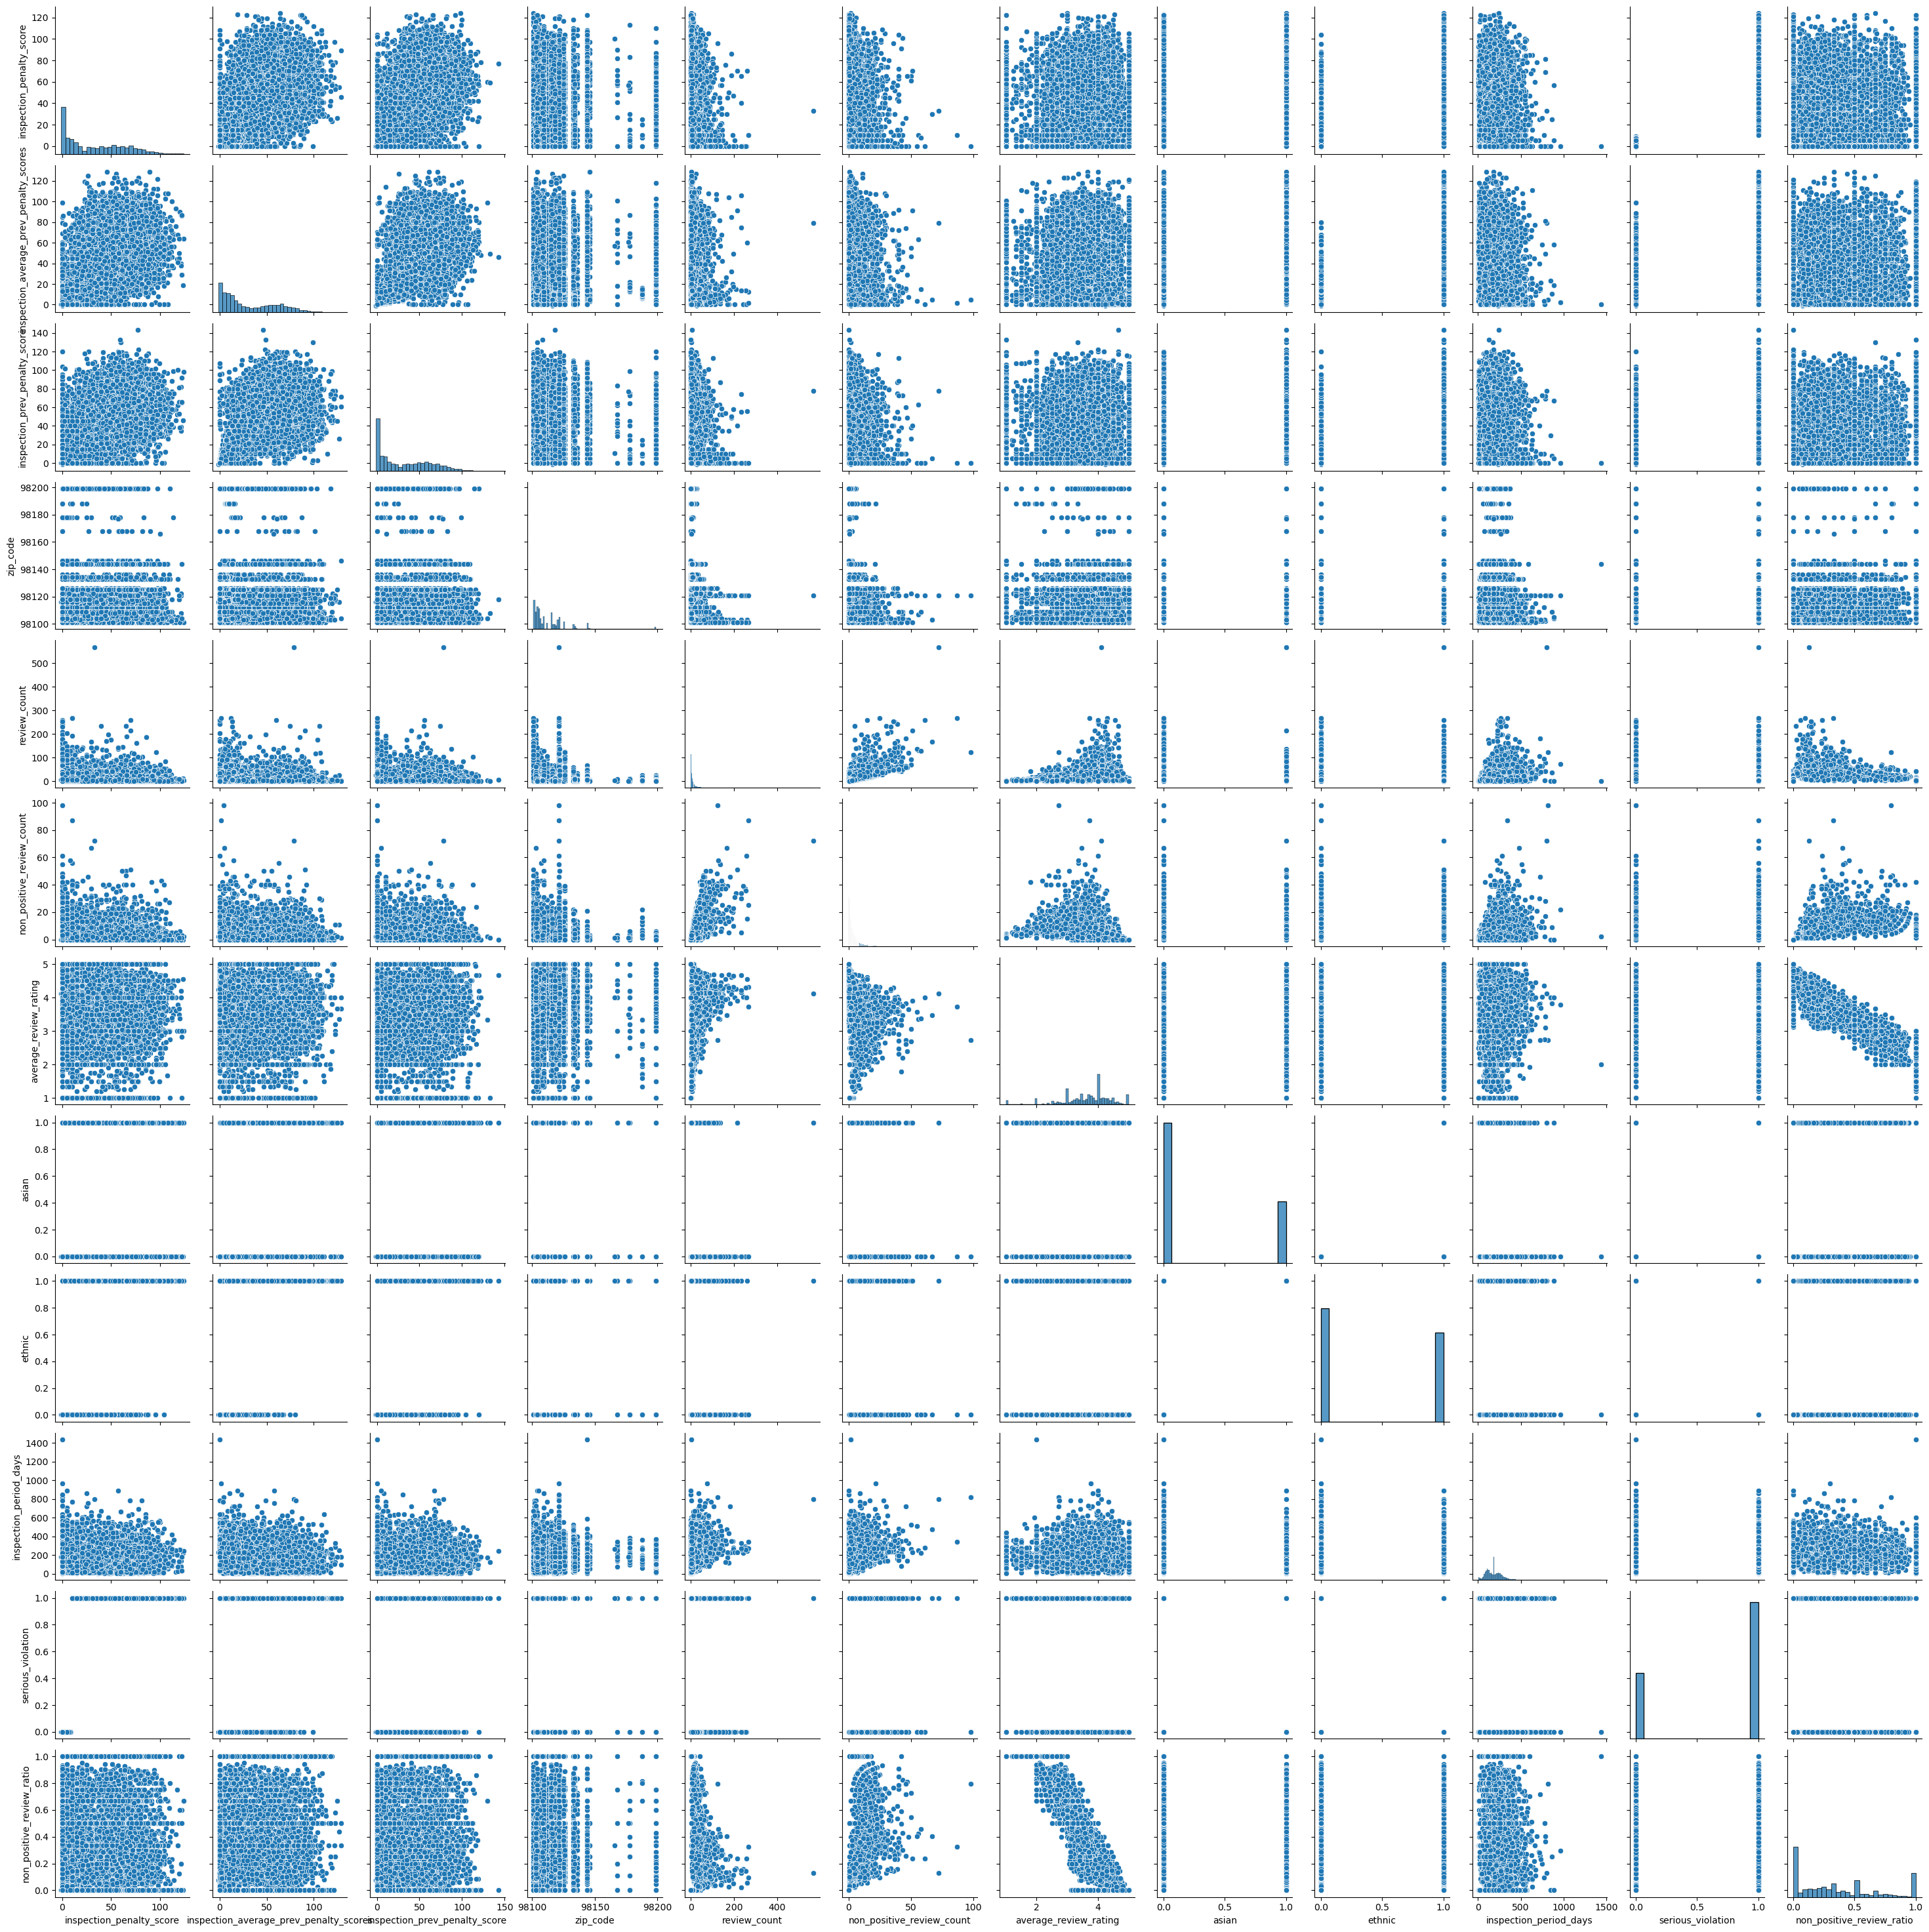

In [116]:
sns.pairplot(df_violation)

<Axes: >

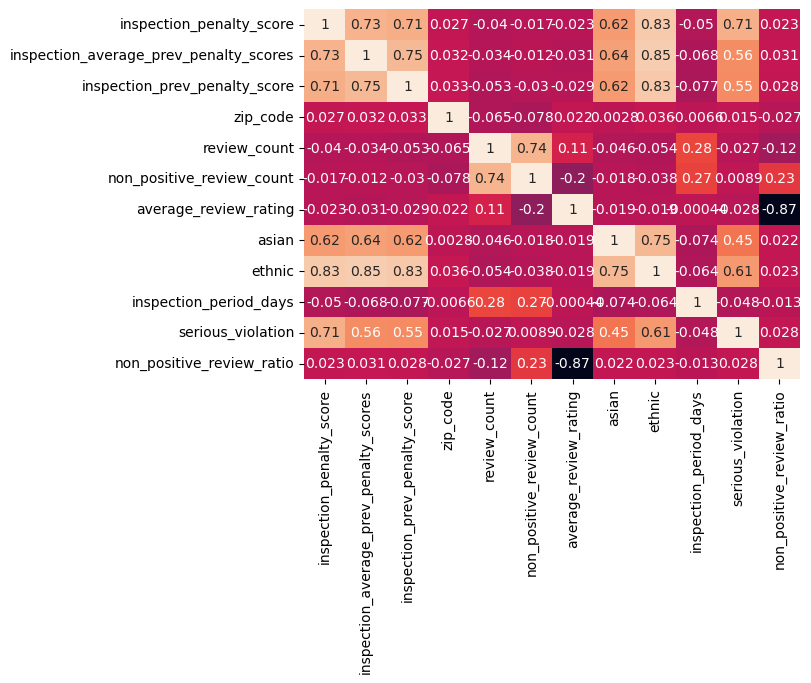

In [120]:
columns_to_exclude = ["restaurant_id", "inspection_period_start_date", "inspection_period_end_date", "cuisines"]
df_corr = df_violation.drop(columns=columns_to_exclude)

corr_matrix = df_corr.corr( )
sns.heatmap(corr_matrix, annot=True, cbar=False)

The variables with the highest correlation to serious_violation are as follows:

- Variables with high correlation to serious_violation:
	- inspection_average_prev_penalty_scores (0.56)
	- inspection_prev_penalty_score (0.55)
	- ethnic (0.61)
	- asian (0.45)

- Variables likely to be insignificant:
	- zip_code (0.015)
	- review_count (-0.027)
	- average_review_rating (0.028)
	- non_positive_review_ratio (0.028)

In [125]:
df_violation.columns

Index(['restaurant_id', 'inspection_period_start_date',
       'inspection_period_end_date', 'inspection_penalty_score',
       'inspection_average_prev_penalty_scores',
       'inspection_prev_penalty_score', 'cuisines', 'zip_code', 'review_count',
       'non_positive_review_count', 'average_review_rating', 'asian', 'ethnic',
       'inspection_period_days', 'serious_violation',
       'non_positive_review_ratio'],
      dtype='object')

### Previous Penalty Score: A Reflection of Past Performance

In [130]:
df_violation["inspection_prev_penalty_score"].describe()

count    13299.000000
mean        31.356869
std         29.720165
min         -1.000000
25%          3.000000
50%         24.000000
75%         56.000000
max        143.000000
Name: inspection_prev_penalty_score, dtype: float64

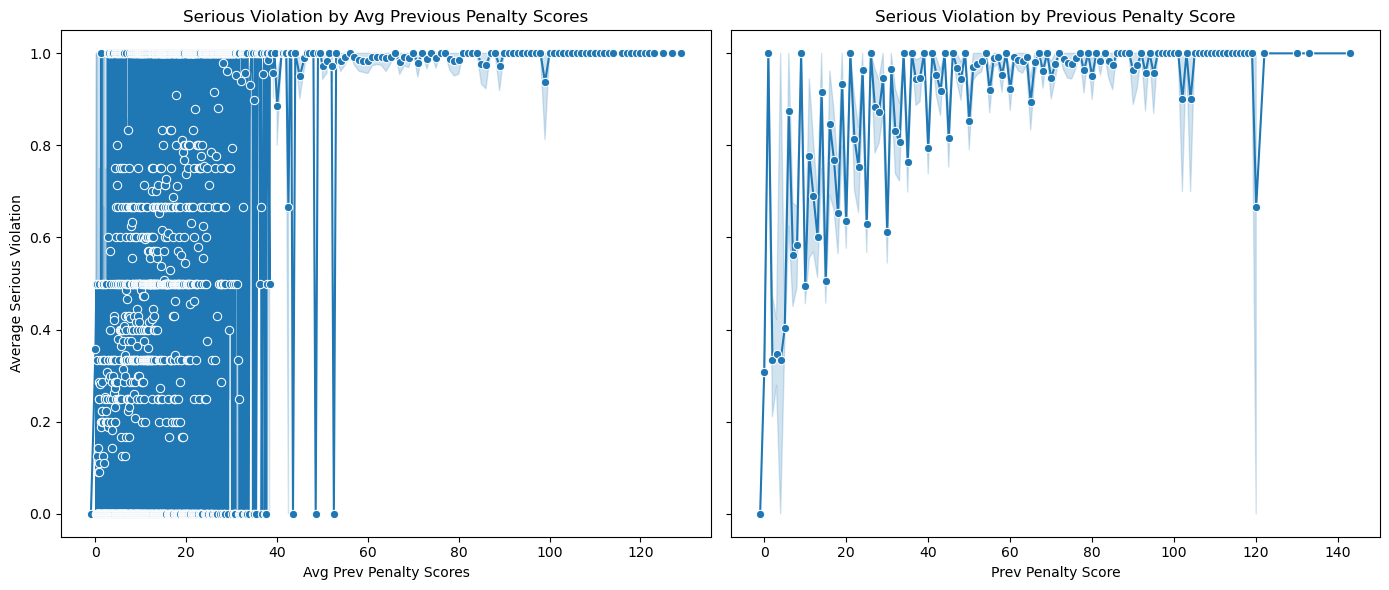

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Line plot for inspection_average_prev_penalty_scores
sns.lineplot(
    ax=axes[0],
    x="inspection_average_prev_penalty_scores",
    y="serious_violation",
    data=df_violation,
    marker="o"
)
axes[0].set_title("Serious Violation by Avg Previous Penalty Scores")
axes[0].set_xlabel("Avg Prev Penalty Scores")
axes[0].set_ylabel("Average Serious Violation")

# Line plot for inspection_prev_penalty_score
sns.lineplot(
    ax=axes[1],
    x="inspection_prev_penalty_score",
    y="serious_violation",
    data=df_violation,
    marker="o"
)
axes[1].set_title("Serious Violation by Previous Penalty Score")
axes[1].set_xlabel("Prev Penalty Score")
axes[1].set_ylabel("Average Serious Violation")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**<Intuition:>** 
- When penalty scores are between 0 and 20, the rate of serious violations shows significant variability. This suggests that even with low penalty scores, the likelihood of violations can vary widely.
- As penalty scores increase beyond 20, the average serious violation rate approaches 1, and the distribution becomes more concentrated. This indicates that individuals with higher past penalty scores are more likely to commit serious violations.

### Ethnic, Asian: Could Ethnicity Play a Role?

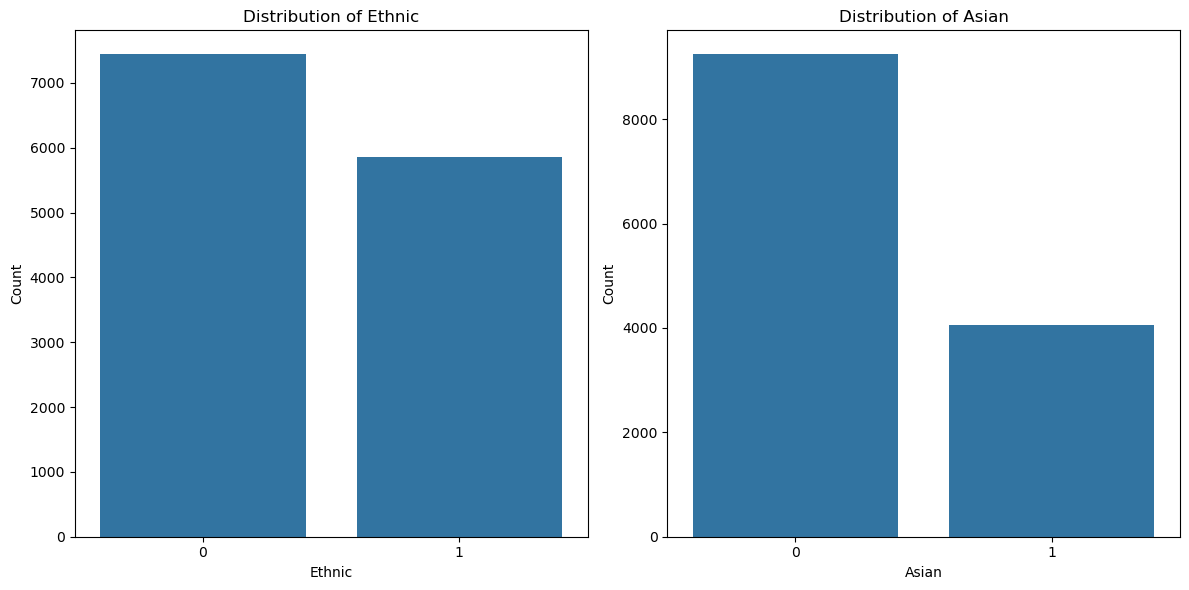

In [126]:
# distribution of ethnic, asian

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of 'ethnic'
sns.countplot(ax=axes[0], x="ethnic", data=df_violation)
axes[0].set_title("Distribution of Ethnic")
axes[0].set_xlabel("Ethnic")
axes[0].set_ylabel("Count")

# Plot distribution of 'asian'
sns.countplot(ax=axes[1], x="asian", data=df_violation)
axes[1].set_title("Distribution of Asian")
axes[1].set_xlabel("Asian")
axes[1].set_ylabel("Count")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

The distributions reveal that individuals or entities classified as ethnic or asian constitute a relatively small portion of the dataset.

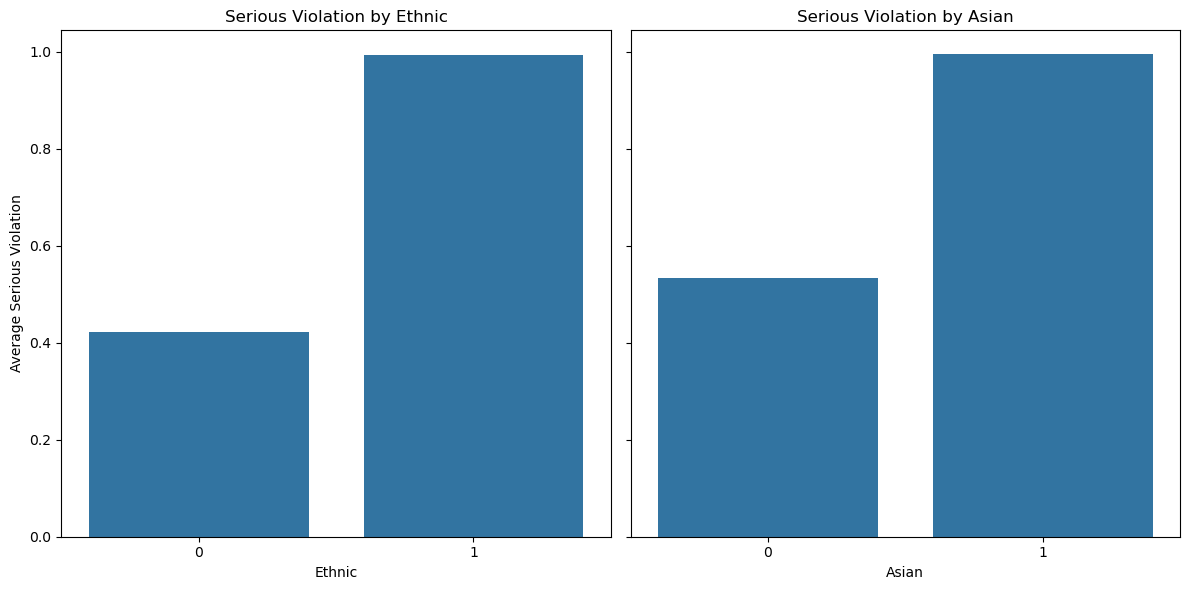

In [ ]:
# Serious violation by ethnic, asian


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Ethnic-based barplot
sns.barplot(
    ax=axes[0],
    x="ethnic",
    y="serious_violation",
    data=df_violation,
    estimator=lambda x: x.mean(),
    ci=None
)
axes[0].set_title("Serious Violation by Ethnic")
axes[0].set_xlabel("Ethnic")
axes[0].set_ylabel("Average Serious Violation")

# Asian-based barplot
sns.barplot(
    ax=axes[1],
    x="asian",
    y="serious_violation",
    data=df_violation,
    estimator=lambda x: x.mean(),
    ci=None
)
axes[1].set_title("Serious Violation by Asian")
axes[1].set_xlabel("Asian")
axes[1].set_ylabel("Average Serious Violation")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**<Intuition:>** 
- The strong relationship between the ethnic, asian variables and serious_violation could reflect differences in operational or cultural practices associated with certain cuisines. For example:
	- Traditional preparation methods: Certain cuisines might involve complex preparation techniques (e.g., raw food, fermentation) that require strict hygiene standards.
	- Ingredient handling: Ethnic cuisines may rely on unique or imported ingredients that could increase risks if improperly stored or managed.

- Complexity of Asian Cuisine: Many Asian cuisines involve intricate preparation techniques, such as:
	- Raw or minimally cooked foods: Examples include sushi, sashimi, or hot pot.
	- Fermentation: Foods like kimchi, soy products, or fermented fish may require careful temperature and storage management.
	- Shared dining formats: Hot pot or dim sum often involves communal dining, which might introduce unique hygiene challenges.


- The observed trend could also reflect biases or inconsistencies in how inspections are conducted for certain ethnic cuisines. For instance:
	- Different focus during inspections: Inspectors might scrutinize specific cuisines more rigorously based on perceived risks or stereotypes.
	- Potential for systemic bias: Restaurants offering ethnic cuisines might be subjected to stricter evaluations due to preconceived notions about their practices.

### Zip Code: Could Location Be a Factor?

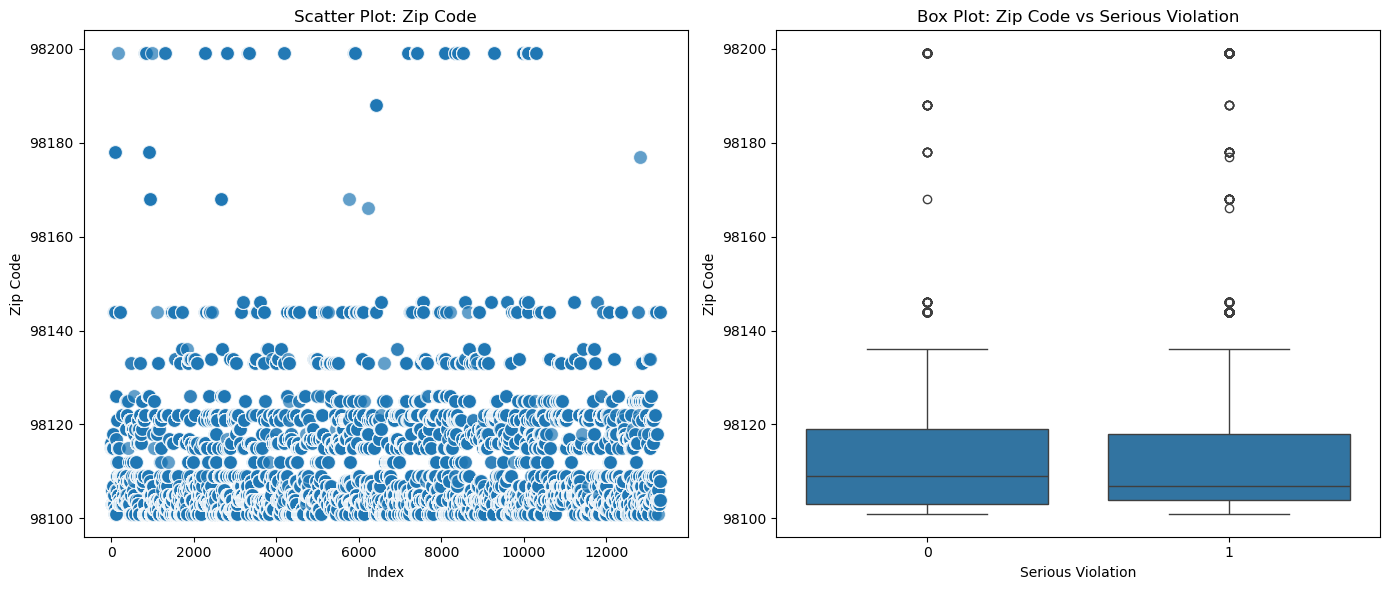

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: zip_code
sns.scatterplot(
    ax=axes[0],
    x=range(len(df_violation)),
    y="zip_code",
    data=df_violation,
    s=100,
    alpha=0.7
)
axes[0].set_title("Scatter Plot: Zip Code")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Zip Code")

# Box plot: zip_code vs serious_violation
sns.boxplot(
    ax=axes[1],
    x="serious_violation",
    y="zip_code",
    data=df_violation
)
axes[1].set_title("Box Plot: Zip Code vs Serious Violation")
axes[1].set_xlabel("Serious Violation")
axes[1].set_ylabel("Zip Code")

# Adjust layout and display
plt.tight_layout()
plt.show()

**<Intuition:>** 
- Scatter plot: Zip code
	- There is a clustering of zip codes around certain values, particularly near 98100 to 98120, suggesting that most data points come from a limited range of zip codes.
	- A few outlier zip codes (e.g., above 98160) are sparsely represented, which could indicate less frequent inspections or fewer restaurants in those regions.

- Box plot: Zip code vs serious violation
	- The median and interquartile range (IQR) for both categories are nearly identical, suggesting that serious violations are not strongly dependent on zip codes.

### Inspection Period Days: Could the Duration of Inspection Have an Impact?
- Start dates: Are violations linked to when inspections begin?
- End dates: Could the timing of inspections' conclusion reveal meaningful patterns?

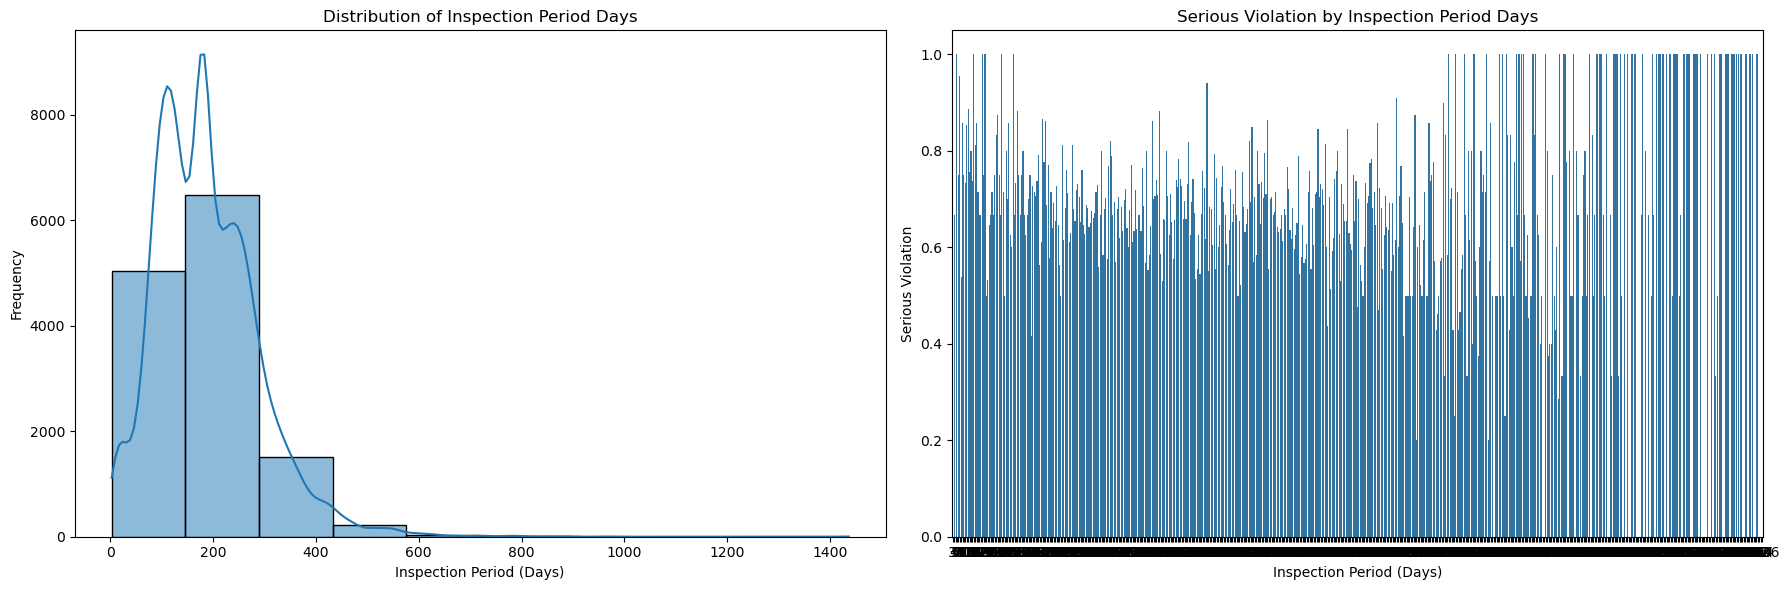

In [155]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Distribution of inspection_period_days
sns.histplot(
    ax=axes[0],
    x="inspection_period_days",
    data=df_violation,
    kde=True,
    bins=10
)
axes[0].set_title("Distribution of Inspection Period Days")
axes[0].set_xlabel("Inspection Period (Days)")
axes[0].set_ylabel("Frequency")

# Bar plot: inspection_period_days vs serious_violation
sns.barplot(
    ax=axes[1],
    x="inspection_period_days",
    y="serious_violation",
    data=df_violation,
    ci=None
)
axes[1].set_title("Serious Violation by Inspection Period Days")
axes[1].set_xlabel("Inspection Period (Days)")
axes[1].set_ylabel("Serious Violation")

# Adjust layout and display
plt.tight_layout()
plt.show()

**<Intuition:>** 
- Generated a variable, "inspection_period_days," from inspection_start_date and inspection_end_date to analyze the effect of inspection duration on serious violations.
- Most inspections were conducted around a duration of 200 days.
- Longer inspection periods tended to result in higher serious violations, but no clear or intuitive pattern was observed between inspection days and serious violations.

### Could Negative Reviews Reflect Compliance Issues?

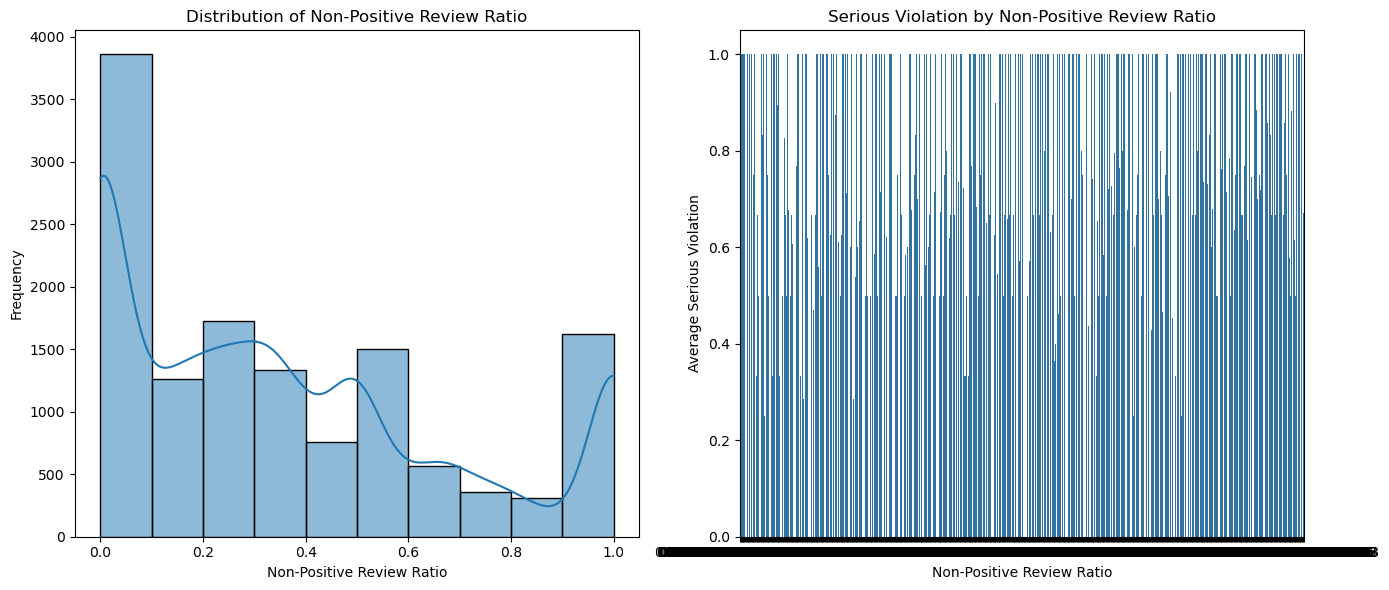

In [140]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot distribution of non_positive_review_ratio
sns.histplot(
    ax=axes[0],
    x="non_positive_review_ratio",
    data=df_violation,
    kde=True,
    bins=10
)
axes[0].set_title("Distribution of Non-Positive Review Ratio")
axes[0].set_xlabel("Non-Positive Review Ratio")
axes[0].set_ylabel("Frequency")

# Bar plot: non_positive_review_ratio vs serious_violation
sns.barplot(
    ax=axes[1],
    x="non_positive_review_ratio",
    y="serious_violation",
    data=df_violation,
    ci=None
)
axes[1].set_title("Serious Violation by Non-Positive Review Ratio")
axes[1].set_xlabel("Non-Positive Review Ratio")
axes[1].set_ylabel("Average Serious Violation")

# Adjust layout and display
plt.tight_layout()
plt.show()

**<Intuition:>** 
- Generated the variable non_positive_review_ratio by dividing non_positive_review_counts by total_review_counts.
- A significant portion of restaurants exhibit a very low non_positive_review_ratio.
- No clear or significant pattern was observed between the non_positive_review_ratio and serious_violation.

# Prediction Models

- Since serious_violation is the target variable inspection_penalty_score is excluded
- Additionally, as inspection_period_start_date and inspection_period_end_date are not numerical values, only inspection_period_days is utilized instead.

In [55]:
df_violation["cuisines"] = df_violation["cuisines"].astype("category")
df_violation["restaurant_id"] = df_violation["restaurant_id"].astype("category")

In [56]:
filter_columns = ("inspection_penalty_score", "serious_violation", 'inspection_period_start_date', 'inspection_period_end_date')

x_data = df_violation[[col for col in df_violation.columns if col not in filter_columns]]
y_data = df_violation["serious_violation"]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

## Encoding

In [57]:
catboost_enc = CatBoostEncoder()
x_train["cuisines"] = catboost_enc.fit_transform(x_train["cuisines"], y_train)
x_test["cuisines"] = catboost_enc.transform(x_test["cuisines"])

catboost_enc2 = CatBoostEncoder()
x_train["restaurant_id"] = catboost_enc.fit_transform(x_train["restaurant_id"], y_train)
x_test["restaurant_id"] = catboost_enc.transform(x_test["restaurant_id"])

## Scaling

In [59]:
scaler = StandardScaler( )
scaler.fit(x_train)
x_train = scaler.transform(x_train)

scaler.fit(x_test)
x_test = scaler.transform(x_test)

## First Level

### Logistic Regression

In [60]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)

# evaluation
roc_score = roc_auc_score(y_test, model_lr.predict_proba(x_test)[:, 1])

cm = confusion_matrix(y_test, y_pred_lr)
cm_df_lr = pd.DataFrame(cm,
					 index = ['Actual Negative', 'Actual Positive'],
					 columns = ['Predicted Negative', 'Predicted Positive'])

cr = classification_report(y_test, y_pred_lr, output_dict = True)
cr_df_lr = pd.DataFrame(cr).transpose()

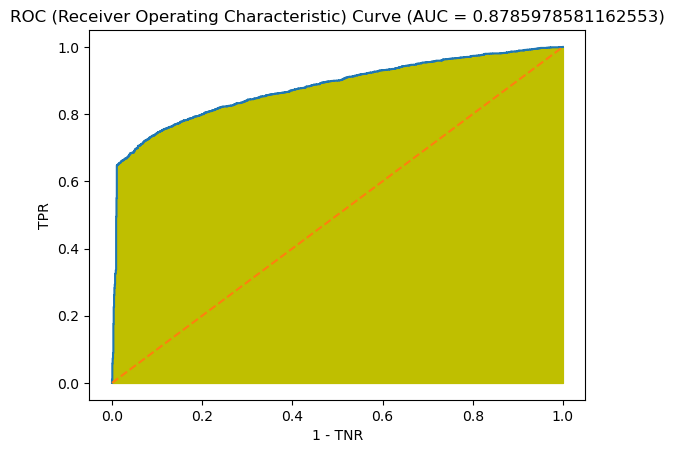

In [61]:
# roc curve plotting
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model_lr.decision_function(x_test))
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='y')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('1 - TNR')
plt.ylabel('TPR')

score = auc(fpr, tpr) 
plt.title('ROC (Receiver Operating Characteristic) Curve (AUC = {})'.format(score))
plt.show()

**<Intuition>**
- X-axis (1 - TNR or FPR, False Positive Rate): represents the rate of false positives
	- the value closer to 0 indicates fewer false positive predictions
- Y-axis (TPR, True Positive Rate): represents the rate of true positives
	- the value closer to 1 indicates better detection of positive instances
- AUC(Area under the curve): represents the area under the ROC curve, summarizing the model's performance as a single value
	- 0.8785: indicates excellent performance significantly better than random
- The curve shows that this model effectively balances true positive detection with minimizing false positives, making it a strong classifier

In [62]:
cm_df_lr

Predicted Negative  Predicted Positive
Actual Negative                1107                 198
Actual Positive                 599                2086

- The confusion matrix provides a detailed breakdown of a classification model's performance by displaying the counts of true and false predictions for each class.
- Performance metrics such as precision, recall, F1-score, and accuracy are derived from the values in the confusion matrix.

In [63]:
cr_df_lr

precision    recall  f1-score      support
0              0.648886  0.848276  0.735304  1305.000000
1              0.913310  0.776909  0.839606  2685.000000
accuracy       0.800251  0.800251  0.800251     0.800251
macro avg      0.781098  0.812592  0.787455  3990.000000
weighted avg   0.826826  0.800251  0.805492  3990.000000

- The classification report provides key performance metrics for classification models, including precision, recall, F1-score, and accuracy.
- Since the primary goal is to evaluate how well the model identifies class 1 (serious_violation), it is necessary to focus on the row corresponding to class 1.

In [36]:
# coefficient

feature_names = x_data.columns if hasattr(x_data, 'columns') else [f"Feature {i}" for i in range(x_train.shape[1])]

coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model_lr.coef_[0],
    "Odds Ratio": np.exp(model_lr.coef_[0])
})

print(coefficients_df)

                                   Feature  Coefficient  Odds Ratio
0                            restaurant_id     0.308998    1.362060
1   inspection_average_prev_penalty_scores     0.800249    2.226096
2            inspection_prev_penalty_score     0.304139    1.355457
3                                 cuisines     0.174934    1.191168
4                                 zip_code    -0.015362    0.984756
5                             review_count    -0.099569    0.905227
6                non_positive_review_count     0.147724    1.159193
7                    average_review_rating    -0.041976    0.958892
8                                    asian     0.063246    1.065289
9                                   ethnic     1.498381    4.474437
10                  inspection_period_days     0.007254    1.007280
11               non_positive_review_ratio    -0.052549    0.948808


**<Intuition:>**
The coefficient indicates how much the log-odds of the target class change with a one-unit increase in the feature value, highlighting the feature's importance in model prediction. The odds ratio represents how the odds (the ratio of the probability of the target outcome to the probability of not having the target outcome) change with a one-unit increase in the feature value.

Since I scaled the variables using a standard scaler before processing them through the model, the coefficient values can be interpreted linearly as the effect of a one standard deviation change in the feature on the log-odds of the target outcome, regardless of the original scale of the feature values.


- Significant features
	- **ethnic**: This feature has the highest odds ratio (4.47), indicating that being classified under the ethnic category significantly increases the likelihood of the target outcome.
	- **Inspection Average Previous Penalty Scores**: Higher average previous penalty scores strongly influence the target, with a one-unit increase leading to a 123%(e^0.80) increase in the odds of the target outcome.
	- **Asian**: This feature shows a moderate positive relationship with the target outcome

- least significant features
	- **zip code**: The coefficient is small (-0.015), and the odds ratio is close to 1 (0.98), suggesting a minimal negative effect on the target.
	- **inspection period days**: The coefficient (0.007) and odds ratio (1.00) indicate a very weak positive impact, making this feature relatively insignificant.
	- **non-positive review ratio**: With a coefficient of -0.05 and an odds ratio of 0.94, this feature shows a small negative relationship with the target and is among the least impactful features.


### SVM

In [92]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf', C=10, gamma=0.1)
model_svm.fit(x_train, y_train)
y_pred_svm = model_svm.predict(x_test)

cr_svm = classification_report(y_test, y_pred_svm, output_dict = True)
cr_df_svm = pd.DataFrame(cr_svm).transpose()

### Decision Tree

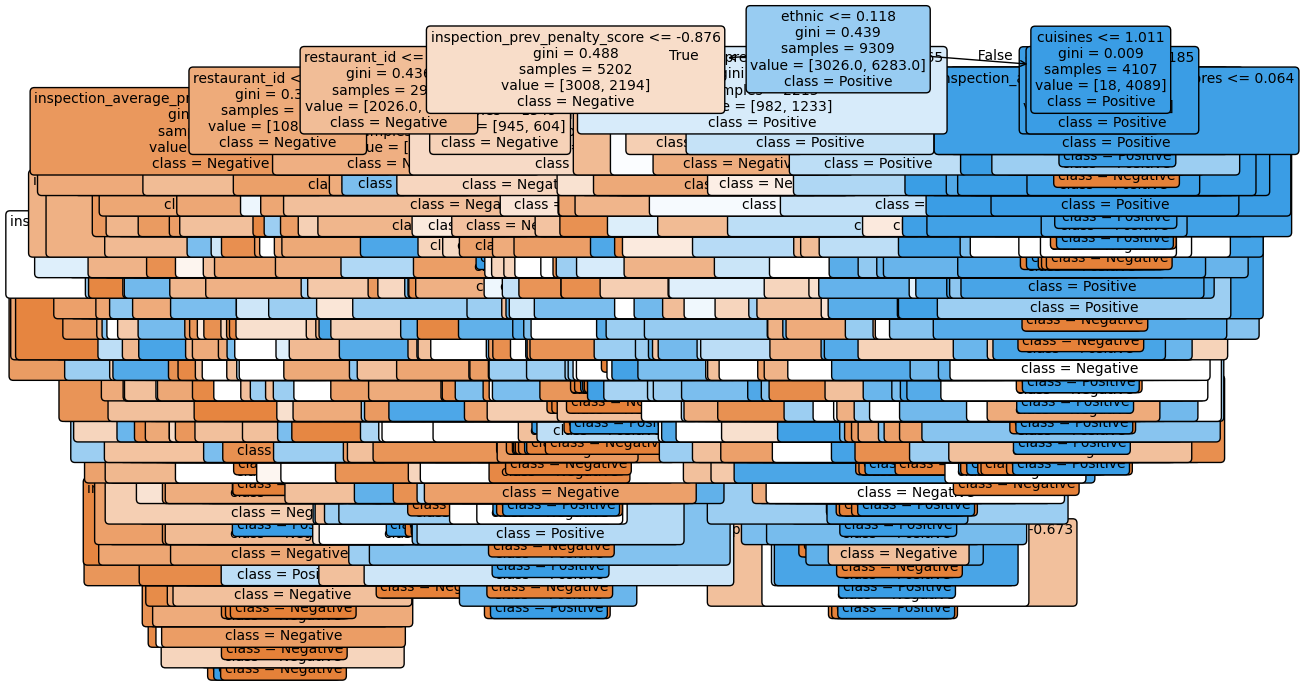

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

model_dt = DecisionTreeClassifier( )
model_dt.fit(x_train, y_train)
y_pred_dt = model_dt.predict(x_test)
cr_dt = classification_report(y_test, y_pred_dt, output_dict=True)
cr_df_dt = pd.DataFrame(cr_dt).transpose()

plt.figure(figsize=(12, 8)) 
plot_tree(model_dt, 
          feature_names=x_data.columns,  
          class_names=["Negative", "Positive"], 
          filled=True, 
          rounded=True,
          fontsize=10) 
plt.show()

### XGBoost

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

model_xgb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)
cr_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
cr_df_xgb = pd.DataFrame(cr_xgb).transpose()

### KNN

In [95]:
model_knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors는 K 값 (default=5)
model_knn.fit(x_train, y_train)
y_pred_knn = model_knn.predict(x_test)
cr_knn = classification_report(y_test, y_pred_knn, output_dict=True)
cr_df_knn = pd.DataFrame(cr_knn).transpose()

### LightGBM

In [96]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(n_estimators=100, max_depth=3, random_state=42)
model_lgb.fit(x_train, y_train)
y_pred_lgb = model_lgb.predict(x_test)
cr_lgb = classification_report(y_test, y_pred_lgb, output_dict=True)
cr_df_lgb = pd.DataFrame(cr_lgb).transpose()

[LightGBM] [Info] Number of positive: 6283, number of negative: 3026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 9309, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.674938 -> initscore=0.730606
[LightGBM] [Info] Start training from score 0.730606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

### Model Performance Comparison

The values were obtained based on the weighted averages: the weighted average for each metric across class 0 and class 1.

In [97]:
metrics_df = pd.DataFrame({
    "Logistic Regression": [
        cr_df_lr.loc["accuracy", "precision"],   
        cr_df_lr.loc["weighted avg", "precision"],
        cr_df_lr.loc["weighted avg", "recall"],  
        cr_df_lr.loc["weighted avg", "f1-score"]  
    ],
    "SVM": [
        cr_df_svm.loc["accuracy", "precision"],   
        cr_df_svm.loc["weighted avg", "precision"],
        cr_df_svm.loc["weighted avg", "recall"],  
        cr_df_svm.loc["weighted avg", "f1-score"]   
    ],
    "Decision Tree": [
        cr_df_dt.loc["accuracy", "precision"],   
        cr_df_dt.loc["weighted avg", "precision"],
        cr_df_dt.loc["weighted avg", "recall"],  
        cr_df_dt.loc["weighted avg", "f1-score"]  
    ],
    "XGBoost": [
        cr_df_xgb.loc["accuracy", "precision"],   
        cr_df_xgb.loc["weighted avg", "precision"],
        cr_df_xgb.loc["weighted avg", "recall"],  
        cr_df_xgb.loc["weighted avg", "f1-score"]   
    ],
    "KNN": [
        cr_df_knn.loc["accuracy", "precision"],   
        cr_df_knn.loc["weighted avg", "precision"],
        cr_df_knn.loc["weighted avg", "recall"],  
        cr_df_knn.loc["weighted avg", "f1-score"]  
    ],
    "LightGBM": [
        cr_df_lgb.loc["accuracy", "precision"],   
        cr_df_lgb.loc["weighted avg", "precision"],
        cr_df_lgb.loc["weighted avg", "recall"],  
        cr_df_lgb.loc["weighted avg", "f1-score"]  
    ]
}, index=["Accuracy", "Precision", "Recall", "F1 Score"]).transpose()

print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.800251   0.826826  0.800251  0.805492
SVM                  0.790727   0.806172  0.790727  0.794940
Decision Tree        0.748371   0.748872  0.748371  0.748616
XGBoost              0.796742   0.800429  0.796742  0.798244
KNN                  0.758897   0.765866  0.758897  0.761589
LightGBM             0.800000   0.807802  0.800000  0.802648


**<Intuition:>** 
- Best model for each metric
	1. Accuracy: Logistic Regression (0.800251)
	This suggests that Logistic Regression is particularly effective in separating the classes using a linear decision boundary.

	2. Precision: Logistic Regression (0.826826)
	Precision reflects the ability of the model to avoid false positives. Logistic Regression's superior precision indicates that it is highly reliable when predicting the positive class.

	3. Recall: Logistic Regression (0.800251)
	Logistic Regression's highest recall suggests that it performs well in identifying all instances of the positive class, indicating its robustness for this metric.

	4. F1-Score: Logistic Regression (0.805492)
	Logistic Regression's highest F1 Score reflects its balanced trade-off between avoiding false positives and capturing true positives.

Logistic Regression demonstrates the best overall performance, likely due to the dataset's characteristics favoring linear decision boundaries and the model's efficiency in balancing precision and recall. While more complex models (e.g., XGBoost, LightGBM) have potential for higher performance, they may not outperform simpler models when the dataset does not justify their complexity.

## Second Level

- Through the analysis of the first-level models, important variables such as ethnic, average previous inspection rate, and asian were identified.
- To further improve classification performance, a new dataset (pred_data) was created based solely on the prediction results of the first-level models. This dataset was then used to train a meta-model, specifically a Decision Tree. Since the new dataset only includes predictions on the x_test data, its size was reduced to 30% of the original dataset. To mitigate overfitting, the meta-model was trained using k-fold cross-validation.

In [98]:
pred_data = pd.DataFrame({
    "logistic Regression": y_pred_lr,
    "SVM": y_pred_svm,
	"Decision Tree": y_pred_dt,
    "XGB": y_pred_xgb,
	"KNN": y_pred_knn,
    "LGBM": y_pred_lgb,
	"True": y_test
})

In [99]:
pred_x = pred_data.iloc[:, :-1]
pred_y = pred_data.iloc[:, -1]

In [101]:
# k-fold meta model training
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

meta_model = DecisionTreeClassifier()
oof_predictions = np.zeros(pred_data.shape[0])
meta_model_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

for train_idx, valid_idx in kf.split(pred_data):
    # Split the data into training and validation sets
    x_train, x_valid = pred_x.iloc[train_idx], pred_x.iloc[valid_idx]
    y_train, y_valid = pred_y.iloc[train_idx], pred_y.iloc[valid_idx]
    
    # Train the meta-model
    meta_model.fit(x_train, y_train)
    
    # Predict on the validation set
    y_valid_pred = meta_model.predict(x_valid)
    oof_predictions[valid_idx] = y_valid_pred
    
    # Calculate metrics
    acc = accuracy_score(y_valid, y_valid_pred)
    precision = precision_score(y_valid, y_valid_pred, average='weighted')
    recall = recall_score(y_valid, y_valid_pred, average='weighted')  # Weighted average for multi-class
    f1 = f1_score(y_valid, y_valid_pred, average='weighted')

    # Append scores
    meta_model_scores['accuracy'].append(acc)
    meta_model_scores['precision'].append(precision)
    meta_model_scores['recall'].append(recall)
    meta_model_scores['f1_score'].append(f1)
    
    print(f"Fold Metrics -> Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Print mean metrics across all folds
print(f"Mean Accuracy: {np.mean(meta_model_scores['accuracy'])}")
print(f"Mean Precision: {np.mean(meta_model_scores['precision'])}")
print(f"Mean Recall: {np.mean(meta_model_scores['recall'])}")
print(f"Mean F1-Score: {np.mean(meta_model_scores['f1_score'])}")

Fold Metrics -> Accuracy: 0.7957393483709273, Precision: 0.8150539386574536, Recall: 0.7957393483709273, F1-Score: 0.8007231799316665
Fold Metrics -> Accuracy: 0.8120300751879699, Precision: 0.8298074194921264, Recall: 0.8120300751879699, F1-Score: 0.8162916482382425
Fold Metrics -> Accuracy: 0.7957393483709273, Precision: 0.8071060234267677, Recall: 0.7957393483709273, F1-Score: 0.7988722172711558
Fold Metrics -> Accuracy: 0.8032581453634086, Precision: 0.8124812481248125, Recall: 0.8032581453634086, F1-Score: 0.8061108135411266
Fold Metrics -> Accuracy: 0.7869674185463659, Precision: 0.8196517700356823, Recall: 0.7869674185463659, F1-Score: 0.793392620901185
Mean Accuracy: 0.7987468671679198
Mean Precision: 0.8168200799473686
Mean Recall: 0.7987468671679198
Mean F1-Score: 0.8030780959766751


In [104]:
metrics_df_with_meta = metrics_df.copy()

meta_results = {
    "Accuracy": 0.798747,
    "Precision": 0.816820,
    "Recall": 0.798747,
    "F1 Score": 0.803078
}

metrics_df_with_meta.loc["Meta"] = meta_results
metrics_df_with_meta

Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.800251   0.826826  0.800251  0.805492
SVM                  0.790727   0.806172  0.790727  0.794940
Decision Tree        0.748371   0.748872  0.748371  0.748616
XGBoost              0.796742   0.800429  0.796742  0.798244
KNN                  0.758897   0.765866  0.758897  0.761589
LightGBM             0.800000   0.807802  0.800000  0.802648
Meta                 0.798747   0.816820  0.798747  0.803078

**<Intuition:>** 

- Best model for each metric
	1. Accuracy:  Logistic Regression (0.800251)
	2. Precision: Meta Model (0.816820)
	3. Recall: Logistic Regression and LightGBM (0.800251 and 0.800000)
	4. F1-Score: Logistic Regression (0.805492)

A stacking model was constructed by combining different models with varying characteristics, including non-linear and linear models, kernel-based methods, distance-based models, and boosting ensemble methods, to better leverage complex data features for classification. However, despite these efforts, the baseline Logistic Regression model performed best.

While techniques like GridSearch or Optuna can be used to fine-tune model parameters and potentially improve performance, these methods may also lead to overfitting, especially on small or noisy datasets.

- Strategies to improve the meta model:
	- feature engineering
	- meta model selection: e.g. gradient boosting as a meta-model
	- hyperparameter optimizations of base models

In [106]:
test_predictions = np.zeros(pred_y.shape[0])

for train_idx, valid_idx in kf.split(pred_data):

    x_train, x_valid = pred_x.iloc[train_idx], pred_x.iloc[valid_idx]
    y_train = pred_y.iloc[train_idx]
    
    meta_model.fit(x_train, y_train)
    

    test_predictions += meta_model.predict(pred_x) / kf.n_splits

bin_test_prediction = (test_predictions >= 0.5).astype(int)

y_pred_meta_df = pd.DataFrame({
    "Prediction Probability": test_predictions,
    "Binary Prediction": bin_test_prediction
})

print(y_pred_meta_df)

      Prediction Probability  Binary Prediction
0                        1.0                  1
1                        0.0                  0
2                        0.0                  0
3                        0.0                  0
4                        0.0                  0
...                      ...                ...
3985                     1.0                  1
3986                     0.0                  0
3987                     0.0                  0
3988                     1.0                  1
3989                     1.0                  1

[3990 rows x 2 columns]


**<Intuition:>** 

After conducting the first-level logistic regression analysis, I identified ethnic, inspection average previous penalty score, and asian as the three most influential factors affecting the likelihood of a serious violation. To enhance the model’s predictive performance by leveraging the strengths of other machine learning approaches, I developed a meta-model. This meta-model integrates predictions from several first-level models, including SVM, Decision Tree, XGBoost, KNN, and LightGBM. These models were chosen to incorporate non-linear relationships and interactions between variables that logistic regression might not capture.

Given that predictions are based on a reduced dataset (test size = 30%) compared to the training dataset, the available data for the meta-model is inherently smaller, increasing the risk of overfitting. To mitigate this, I implemented k-fold cross-validation during the training process. This approach ensures that the model generalizes well to unseen data by systematically validating across multiple splits.

Despite these advanced techniques, the predictive accuracy of the meta-model remained consistent with the logistic regression model at approximately 80%. This suggests that while the additional models bring robustness, the logistic regression already captured the primary structure of the data effectively.

Building models with features like ethnic, inspection average previous penalty score, and asian provides valuable intuition for developing targeted policies. For example:

Ethnic and asian indicators might reflect cultural or operational patterns that influence compliance behavior.
Inspection average previous penalty scores serve as a clear signal of historical risk, enabling the allocation of resources to higher-risk restaurants.
By leveraging these insights, regulators can better allocate inspection resources, prioritize high-risk establishments, and implement education or outreach programs tailored to specific groups or operational practices.



- Additional Data That Could Improve the Model
	- Restaurant Size and Capacity: The number of customers served daily or seating capacity could provide insights into operational complexity and potential compliance risks.
	- Employee Training or Certification Data: Information on whether employees have formal health and safety training could indicate the likelihood of compliance with regulations.
	- Customer Demographics:Demographics of the customer base might influence review behavior and inspection targeting.


- Alternative Modeling Approach: 
	- Clustering Models: Grouping restaurants with similar operational or violation patterns could enable targeted strategies for compliance improvement.
	- Time-Series Modeling:: Incorporating temporal patterns of inspections and violations could allow regulators to anticipate future violations based on historical trends.

# Regression Models

### Data Preprocessing

In [123]:
df_violation["cuisines"] = df_violation["cuisines"].astype("category")
df_violation["restaurant_id"] = df_violation["restaurant_id"].astype("category")

- train-test split

In [124]:
filter_columns = ("serious_violation", "inspection_penalty_score", 'inspection_period_start_date', 'inspection_period_end_date')

x_data_reg = df_violation[[col for col in df_violation.columns if col not in filter_columns]]
y_data_reg = df_violation["inspection_penalty_score"]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_data_reg, y_data_reg, test_size=0.3)

- encoding & scaling

In [125]:
from category_encoders import CatBoostEncoder

catboost_enc = CatBoostEncoder()
x_train_reg["cuisines"] = catboost_enc.fit_transform(x_train_reg["cuisines"], y_train_reg)
x_test_reg["cuisines"] = catboost_enc.transform(x_test_reg["cuisines"])

catboost_enc2 = CatBoostEncoder()
x_train_reg["restaurant_id"] = catboost_enc.fit_transform(x_train_reg["restaurant_id"], y_train_reg)
x_test_reg["restaurant_id"] = catboost_enc.transform(x_test_reg["restaurant_id"])

## Linear Regression

Discovering that Logistic Regression demonstrated the best performance, suggesting the presence of a linear boundary and a balanced dataset, I further explored the possibility of directly predicting the inspection_penalty_score using Linear Regression.

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_linear = LinearRegression( )
model_linear.fit(x_train_reg, y_train_reg)
y_pred_linear = model_linear.predict(x_test_reg)

eval_metrics_linear = pd.DataFrame({
    "Metric": ["Mean Absolute Error", "Mean Squared Error", "R2 Score"],
    "Value": [
        mean_absolute_error(y_test_reg, y_pred_linear),
        mean_squared_error(y_test_reg, y_pred_linear),
        r2_score(y_test_reg, y_pred_linear)
    ]
})

print(eval_metrics_linear)

                Metric       Value
0  Mean Absolute Error   12.267211
1   Mean Squared Error  266.225290
2             R2 Score    0.692174


- Comparison of the distributions of y_pred_linear and y_test

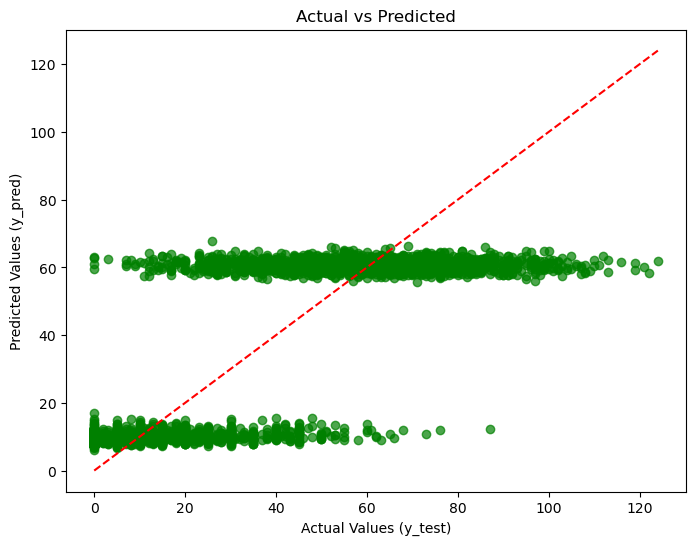

In [136]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_linear, alpha=0.7, color='green')
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted')
plt.show()

The scattered points represent the predicted values of the dependent variable y based on the linear regression model, while the red dashed line represents a perfect linear relationship. From the plot, it is evident that there is no strong linear relationship between the features x and the target variable y.

Additionally, the r2 score of the model is 0.69, indicating that the model accounts for 69% of the variance in the target variable's distribution. While this performance is better than a random prediction, it still lacks sufficient explanatory power to reliably model the relationship.

## SVR

- Scaling: SVR requires scaling, unlike Linear Regression.

In [126]:
scaler = StandardScaler( )
scaler.fit(x_train_reg)
x_train_reg_scaled = scaler.transform(x_train_reg)

scaler.fit(x_test_reg)
x_test_reg_scaled = scaler.transform(x_test_reg)

In [128]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_svr = SVR(kernel='rbf', C=1.0, gamma='auto')
model_svr.fit(x_train_reg_scaled, y_train_reg)

y_pred_svr = model_svr.predict(x_test_reg_scaled)

eval_metrics_svr = pd.DataFrame({
    "Metric": ["Mean Absolute Error", "Mean Squared Error", "R2 Score"],
    "Value": [
        mean_absolute_error(y_test_reg, y_pred_svr),
        mean_squared_error(y_test_reg, y_pred_svr),
        r2_score(y_test_reg, y_pred_svr)
    ]
})

print(eval_metrics_svr)

                Metric       Value
0  Mean Absolute Error   12.140107
1   Mean Squared Error  275.867348
2             R2 Score    0.681025


- Comparison of the distributions of y_pred_svr and y_test

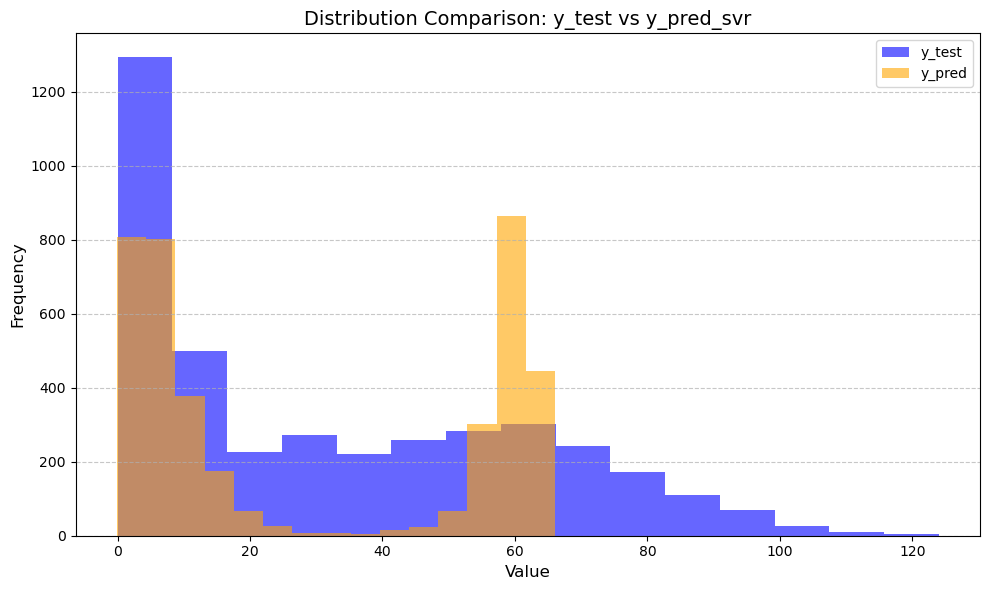

In [129]:
plt.figure(figsize=(10, 6))

plt.hist(y_test_reg, bins=15, alpha=0.6, color='blue', label='y_test')
plt.hist(y_pred_svr, bins=15, alpha=0.6, color='orange', label='y_pred')

plt.title("Distribution Comparison: y_test vs y_pred_svr", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

Since y_pred_svr consists of float values, I used a histogram to compare its distribution with y_test. The R2 score is approximately 0.68, indicating that the model accounts for about 68% of the variance in the target variable.

However, the MAE and MSE reveal significant prediction errors:

- MAE: The average absolute difference between predicted values (y_pred) and actual values (y_test) is about 12.14
- MSE: The average squared difference between predicted and actual values is approximately 275.86

# Clustering

To better understand the features of the dataset associated with committing serious violations, I performed a clustering analysis. I divided the clusters using only the x variables, excluding "serious_violation", "inspection_penalty_score", "inspection_period_start_date", and "inspection_period_end_date".

### Data Preprocessing

- The encoder will be replaced with a Label Encoder, as CatBoost Encoder is more appropriate for supervised learning tasks.
- Additionally, instead of splitting the data into x_train and x_test, the entire x_data will be used for clustering analysis.
- Unlike in the classification and regression models, where inspection_period_start_date and inspection_period_end_date were excluded (since inspection_period_days was already included as a variable), these two variables will now be added for the clustering analysis.

In [159]:
df_violation["cuisines"] = df_violation["cuisines"].astype("category")
df_violation["restaurant_id"] = df_violation["restaurant_id"].astype("category")

In [160]:
filter_columns = ("serious_violation", "inspection_penalty_score")

x_data_cl = df_violation[[col for col in df_violation.columns if col not in filter_columns]]
y_data_cl = df_violation["serious_violation"]

- encoding & scaling

In [161]:
from sklearn.preprocessing import LabelEncoder

le_cuisines = LabelEncoder()
le_restaurant_id = LabelEncoder()
le_start = LabelEncoder()
le_end = LabelEncoder()

x_data_cl["cuisines"] = le_cuisines.fit_transform(x_data_cl["cuisines"])
x_data_cl["restaurant_id"] = le_restaurant_id.fit_transform(x_data_cl["restaurant_id"])
x_data_cl['inspection_period_start_date'] = le_start.fit_transform(x_data_cl['inspection_period_start_date'])
x_data_cl['inspection_period_end_date'] = le_end.fit_transform(x_data_cl['inspection_period_end_date'])

In [162]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler( )
scaler.fit(x_data_cl)
x_data_cl_scaled = scaler.transform(x_data_cl)

# Convert scaled data(ndarray) back to DataFrame
x_data_cl_scaled = pd.DataFrame(x_data_cl_scaled, columns=x_data_cl.columns, index=x_data_cl.index)

## K-Means Clustering

In [163]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(x_data_cl_scaled)
x_data_cl_scaled['cluster'] = kmeans.labels_

- Visualizing clusters by using PCA to reduce the data to two dimensions (x, y)

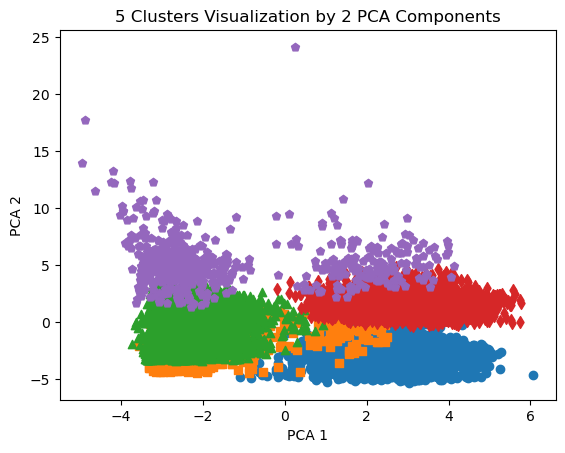

In [166]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

pca_transformed = pca.fit_transform(x_data_cl_scaled)
x_data_cl_scaled['pca_x'] = pca_transformed[:,0]
x_data_cl_scaled['pca_y'] = pca_transformed[:, 1]

marker0_ind = x_data_cl_scaled[x_data_cl_scaled['cluster']==0].index
marker1_ind = x_data_cl_scaled[x_data_cl_scaled['cluster']==1].index
marker2_ind = x_data_cl_scaled[x_data_cl_scaled['cluster']==2].index
marker3_ind = x_data_cl_scaled[x_data_cl_scaled['cluster']==3].index
marker4_ind = x_data_cl_scaled[x_data_cl_scaled['cluster']==4].index

plt.scatter(x=x_data_cl_scaled.loc[marker0_ind,'pca_x'], y=x_data_cl_scaled.loc[marker0_ind,'pca_y'], marker='o') 
plt.scatter(x=x_data_cl_scaled.loc[marker1_ind,'pca_x'], y=x_data_cl_scaled.loc[marker1_ind,'pca_y'], marker='s')
plt.scatter(x=x_data_cl_scaled.loc[marker2_ind,'pca_x'], y=x_data_cl_scaled.loc[marker2_ind,'pca_y'], marker='^')
plt.scatter(x=x_data_cl_scaled.loc[marker3_ind,'pca_x'], y=x_data_cl_scaled.loc[marker3_ind,'pca_y'], marker='d')
plt.scatter(x=x_data_cl_scaled.loc[marker4_ind,'pca_x'], y=x_data_cl_scaled.loc[marker4_ind,'pca_y'], marker='p')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('5 Clusters Visualization by 2 PCA Components')
plt.show()

- Stacked bar plot: relationship between the clusters (5 categories) and serious_violation (binary)

In [169]:
x_data_cl_scaled['serious_violation'] = y_data_cl

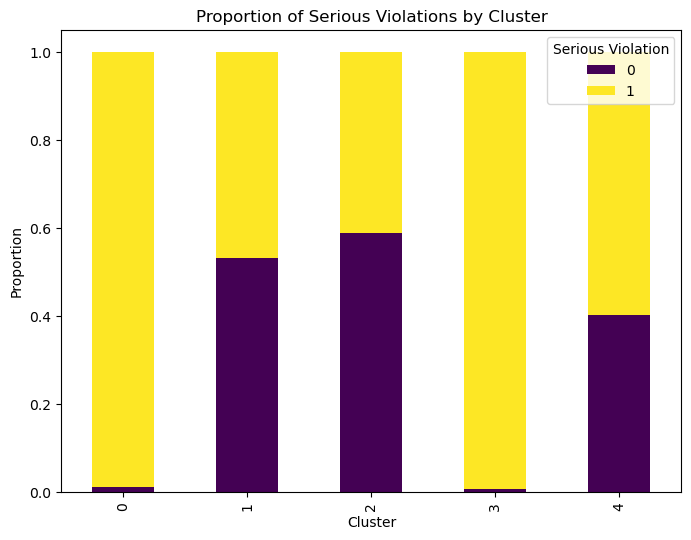

In [170]:
# Grouping data for proportions
grouped = x_data_cl_scaled.groupby(['cluster', 'serious_violation']).size().unstack(fill_value=0)
proportions = grouped.div(grouped.sum(axis=1), axis=0)

# Plot
proportions.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')
plt.title('Proportion of Serious Violations by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Serious Violation')
plt.show()

Clusters 0 and 3 have a high proportion of serious violations

- Statistics of clusters (mean, std, min, max)

In [178]:
cluster_stats = x_data_cl_scaled.groupby('cluster').agg(['mean', 'std', 'min', 'max'])
cluster_stats = pd.DataFrame(cluster_stats).transpose()
cluster_stats

cluster                                   0         1         2         3  \
restaurant_id                mean  0.073266  0.078950 -0.084064  0.029869   
                             std   0.986892  1.025345  0.994212  0.992211   
                             min  -1.689136 -1.704919 -1.706892 -1.689136   
                             max   1.755540  1.749622  1.743703  1.755540   
inspection_period_start_date mean -1.022667  0.081812 -0.109305  0.754386   
...                                     ...       ...       ...       ...   
pca_y                        max  -0.039723  2.605839  3.698958  4.827219   
serious_violation            mean  0.989064  0.467406  0.411314  0.994279   
                             std   0.104025  0.499047  0.492123  0.075433   
                             min   0.000000  0.000000  0.000000  0.000000   
                             max   1.000000  1.000000  1.000000  1.000000   

cluster                                    4  
restaurant_id                mean  -0.063867  
                             std    0.991881  
                             min   -1.687163  
                             max    1.745676  
inspection_period_start_date mean   0.287270  
...                                      ...  
pca_y                        max   24.131560  
serious_violation            mean   0.599018  
                             std    0.490499  
                             min    0.000000  
                             max    1.000000  

[68 rows x 5 columns]

- Visualizing the distribution of each cluster for the following features

In [182]:
columns = [
    "restaurant_id", "inspection_period_start_date", "inspection_period_end_date",
    "inspection_average_prev_penalty_scores", "inspection_prev_penalty_score", 
    "cuisines", "zip_code", "review_count", "non_positive_review_count",
    "average_review_rating", "asian", "ethnic", "inspection_period_days", 
    "non_positive_review_ratio", "serious_violation"
]

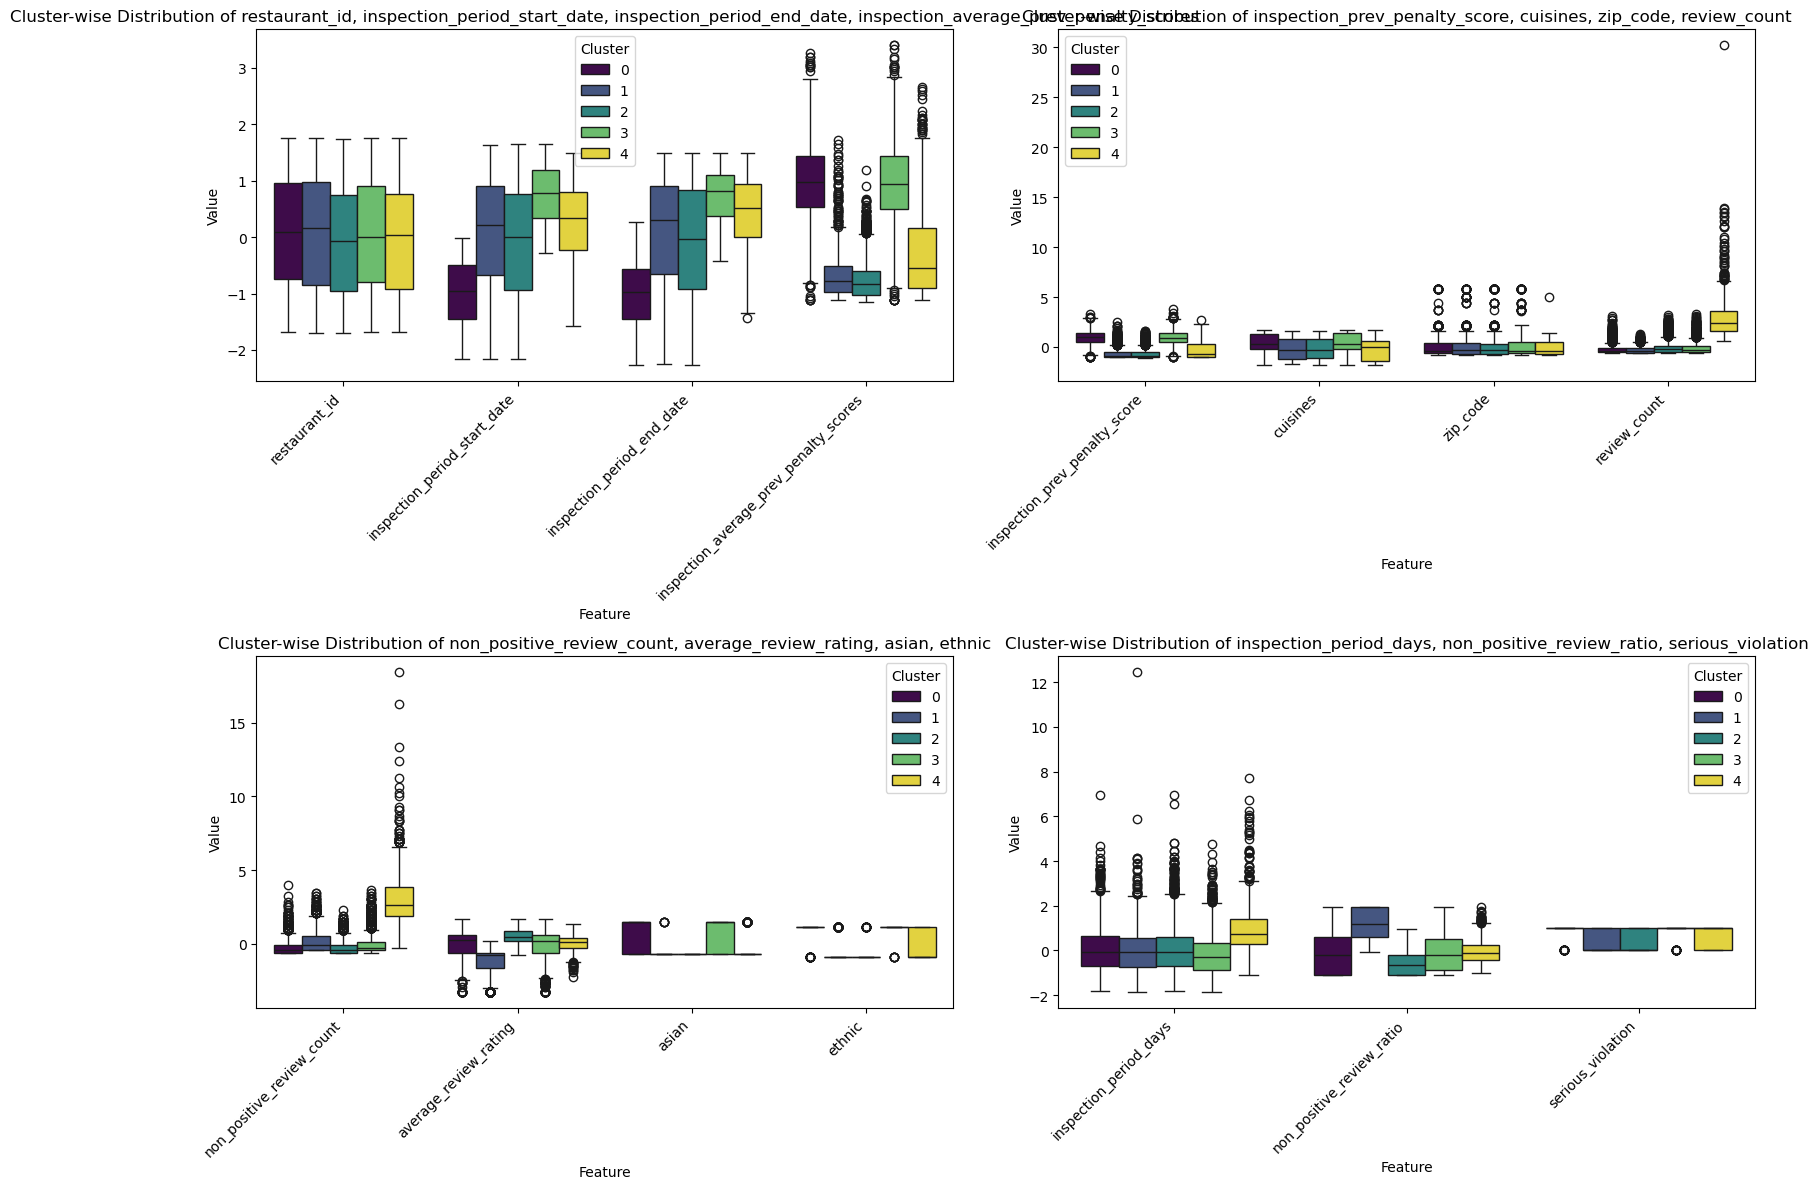

In [ ]:
columns_per_plot = 4
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# First subplot: first set of features
selected_columns_1 = columns[:columns_per_plot]

melted_1 = pd.melt(
    x_data_cl_scaled, 
    id_vars=['cluster'], 
    value_vars=selected_columns_1, 
    var_name='Feature', 
    value_name='Value'
)

sns.boxplot(
    data=melted_1, 
    x='Feature', 
    y='Value', 
    hue='cluster', 
    ax=axes[0, 0], 
    palette='viridis'
)

axes[0, 0].set_title(f"Cluster-wise Distribution of {', '.join(selected_columns_1[:4])}")
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].legend(title="Cluster")

# Second subplot: second set of features
selected_columns_2 = columns[columns_per_plot:columns_per_plot * 2]

melted_2 = pd.melt(
    x_data_cl_scaled, 
    id_vars=['cluster'], 
    value_vars=selected_columns_2, 
    var_name='Feature', 
    value_name='Value'
)

sns.boxplot(
    data=melted_2, 
    x='Feature', 
    y='Value', 
    hue='cluster', 
    ax=axes[0, 1], 
    palette='viridis'
)

axes[0, 1].set_title(f"Cluster-wise Distribution of {', '.join(selected_columns_2[:4])}")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].legend(title="Cluster")

# Third subplot: third set of features
selected_columns_3 = columns[columns_per_plot * 2:columns_per_plot * 3]

melted_3 = pd.melt(
    x_data_cl_scaled, 
    id_vars=['cluster'], 
    value_vars=selected_columns_3, 
    var_name='Feature', 
    value_name='Value'
)

sns.boxplot(
    data=melted_3, 
    x='Feature', 
    y='Value', 
    hue='cluster', 
    ax=axes[1, 0], 
    palette='viridis'
)

axes[1, 0].set_title(f"Cluster-wise Distribution of {', '.join(selected_columns_3[:4])}")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].legend(title="Cluster")

# Fourth subplot: fourth set of features
selected_columns_4 = columns[columns_per_plot * 3:]

melted_4 = pd.melt(
    x_data_cl_scaled, 
    id_vars=['cluster'], 
    value_vars=selected_columns_4, 
    var_name='Feature', 
    value_name='Value'
)

sns.boxplot(
    data=melted_4, 
    x='Feature', 
    y='Value', 
    hue='cluster', 
    ax=axes[1, 1], 
    palette='viridis'
)

axes[1, 1].set_title(f"Cluster-wise Distribution of {', '.join(selected_columns_4[:4])}")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].legend(title="Cluster")

# Adjust layout
plt.tight_layout()
plt.show()

When examining the average values and the presence of distributions, the characteristics of each cluster were as follows:

- Cluster 0:
	- The average values for inspection_period_start_date and inspection_period_end_date are low
	- The average values for inspection_average_prev_penalty_score and inspection_prev_penalty_score are high
	- There is notable variation or distribution in the asian variable
- Cluster 1:
	- non_positive_review_ratio is high
	The asian variable is mostly close to 0, with some outliers present
- Cluster 2:
	- The asian variable is also mostly close to 0, with some outliers present
- Cluster 3:
	- The average values for inspection_average_prev_penalty_score and inspection_prev_penalty_score are high
	- There is notable variation or distribution in the asian variable
- Cluster 4:
	- review_count is high
	- non_positive_review_count is high
	- The average value for inspection_period_days is high

In clusters 0 and 3, where the proportion of serious violations with a value of 1 was high, notable patterns were observed in the variables inspection_average_prev_penalty_score, inspection_prev_penalty_score, and asian. This aligns with the earlier model explanations, where these variables demonstrated high feature importance in the classification task.

# Conclusion

Based on the regression analysis, I identified inspection_average_prev_penalty_score, inspection_prev_penalty_score, as well as the asian and ethnic variables as the most important features influencing the classifier's predictions, as evidenced by their coefficients and odds ratios.

I constructed a two-level stacked classification model to leverage the strengths of different classifiers, including those that handle linear and non-linear relationships, kernel-based methods, distance-based approaches, and boosting-based methods. However, logistic regression outperformed all other models. This suggests the possibility of a linear decision boundary and indicates that the dataset is balanced. While further hyperparameter tuning and adjustments to error costs or thresholds could improve performance, the results imply that logistic regression is inherently well-suited for this problem.

To explore regression further, I developed two models: linear regression and SVR with an RBF kernel. These models targeted the penalty score (inspection_penalty_score) directly rather than focusing on serious_violation. Both models achieved an R² score of approximately 0.69, demonstrating better performance than random guessing but still leaving a considerable explanatory gap.

Cluster analysis was conducted to uncover the characteristics of groups related to serious_violation. Clusters were differentiated based on asian, ethnicity, prev_penalty_score, and non_positive_review_count. Clusters with higher means in inspection_average_prev_penalty_score, inspection_prev_penalty_score, and asian showed higher proportions of serious_violation (value = 1), aligning with the findings from the classification model.

Interestingly, this analysis contradicted my initial hypothesis that variables such as inspection_period_days (inspection duration) or location-based factors like zipcode might influence serious_violation. I created new variables related to inspection_period_days and other factors, but their coefficients were low, suggesting that these variables were not significant in predicting serious_violation.


- Practical Application

By identifying inspection_average_prev_penalty_score and inspection_prev_penalty_score as key features, regulatory bodies can focus on businesses with poor compliance history. This could help optimize inspection schedules and allocate resources more effectively.

Businesses can use the clustering analysis to understand the key factors (e.g., customer dissatisfaction, ethnicity-specific trends) driving violations and take corrective measures to improve compliance.

By combining classification, regression, and clustering approaches, this analysis provides a comprehensive framework for understanding and addressing serious_violation while paving the way for broader applications in regulatory and compliance contexts.